## PHẦN 1: CÀI ĐẶT, IMPORTS & THIẾT LẬP BAN ĐẦU

In [20]:
# ==============================================================================
# CELL 1.1: CÀI ĐẶT THƯ VIỆN & BIẾN MÔI TRƯỜNG (CẬP NHẬT)
# ==============================================================================
import os
import json
import asyncio
import operator
import time 
import re
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union

# Tải các biến môi trường
from dotenv import load_dotenv 
load_dotenv()

# LangChain & LangGraph
from langchain_core.messages import BaseMessage, HumanMessage   
from pydantic.v1 import BaseModel, Field, schema_json_of
# --- NÂNG CẤP: Chuyển sang thư viện Google Generative AI (dành cho AI Studio) ---
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# --- NÂNG CẤP: Thêm công cụ tìm kiếm ---
from langchain_community.tools.tavily_search import TavilySearchResults

# Thư viện hỗ trợ & Kho tri thức
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from rich.console import Console
from rich.markdown import Markdown
from rich.pretty import pprint
from IPython.display import Image, display

In [21]:
# ==============================================================================
# CELL 1.2: CẤU HÌNH LOG & CÁC HÀM IN ẤN
# ==============================================================================
from langchain_groq import ChatGroq
# --- CẤU HÌNH LOG ---
VERBOSE_MODE = True

# --- KHỞI TẠO CÁC CÔNG CỤ IN ẤN ---
console = Console()

def print_step(message: str):
    if VERBOSE_MODE:
        console.print(f"\n[bold cyan]>[/bold cyan] {message}")

def print_result(data: Any, title: str = "Kết quả"):
    if VERBOSE_MODE:
        console.print(f"[bold green]✔️ {title}:[/bold green]")
        pprint(data, expand_all=True)
        
def print_warning(message: str):
    if VERBOSE_MODE:
        console.print(f"[bold yellow]⚠️  {message}[/bold yellow]")

In [22]:
# ==============================================================================
# CELL 1.3: KHỞI TẠO LLM (NÂNG CẤP SANG GOOGLE AI STUDIO)
# ==============================================================================
try:
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash", # Sử dụng model mới nhất và mạnh nhất
        temperature=0.1,
        google_api_key=os.getenv("GOOGLE_API_KEY")
    )
    print("✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.")
except Exception as e:
    print(f"❌ LỖI: Không thể khởi tạo LLM. Hãy chắc chắn bạn đã cài 'langchain-google-genai' và có GOOGLE_API_KEY trong file .env. Lỗi: {e}")
    llm = None

✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.


## PHẦN 2: ĐỊNH NGHĨA STATE CỦA HỆ THỐNG


In [23]:
# ==============================================================================
# CELL 1.4: TẢI KHO TRI THỨC (RAG)
# ==============================================================================
# --- TẢI KHO TRI THỨC ---
BASE_VECTOR_STORE_PATH = "vector_store"
vector_store = None
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

if os.path.exists(BASE_VECTOR_STORE_PATH):
    subdirectories = [f.path for f in os.scandir(BASE_VECTOR_STORE_PATH) if f.is_dir()]
    if not subdirectories:
        print(f"❌ LỖI: Không tìm thấy thư mục con nào trong '{BASE_VECTOR_STORE_PATH}'.")
    else:
        try:
            print_step(f"Đang tải và hợp nhất các kho tri thức từ {len(subdirectories)} thư mục...")
            # Tải kho tri thức đầu tiên để làm cơ sở
            first_store_path = subdirectories.pop(0)
            vector_store = FAISS.load_local(first_store_path, embeddings, allow_dangerous_deserialization=True)
            print(f"✅ Đã tải thành công kho tri thức cơ sở: '{os.path.basename(first_store_path)}'")

            # Hợp nhất các kho tri thức còn lại
            for store_path in subdirectories:
                if os.path.exists(os.path.join(store_path, "index.faiss")):
                    temp_store = FAISS.load_local(store_path, embeddings, allow_dangerous_deserialization=True)
                    vector_store.merge_from(temp_store)
                    print(f"✅ Đã hợp nhất thành công: '{os.path.basename(store_path)}'")
                else:
                    print_warning(f"Bỏ qua thư mục '{os.path.basename(store_path)}' vì không chứa file index.faiss.")
            
            print("\n[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]")

        except Exception as e:
            print(f"❌ LỖI trong quá trình tải hoặc hợp nhất kho tri thức: {e}")
else:
    print(f"❌ LỖI: Không tìm thấy thư mục gốc của kho tri thức tại '{BASE_VECTOR_STORE_PATH}'.")


> Đang tải và hợp nhất các kho tri thức từ 2 thư mục...

✅ Đã tải thành công kho tri thức cơ sở: 'sgk_toan_12_1'
✅ Đã hợp nhất thành công: 'sgk_toan_9_1'

[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]


In [24]:
# ==============================================================================
# CELL 1.5: KHỞI TẠO VÀ QUẢN LÝ TRÍ NHỚ DÀI HẠN (NÂNG CẤP V9.4)
# ==============================================================================
MEMORY_FILE_PATH = "long_term_memory.json"
memory_vector_store = None

# Hàm để tải trí nhớ từ file JSON
def load_memory():
    if not os.path.exists(MEMORY_FILE_PATH):
        return []
    with open(MEMORY_FILE_PATH, 'r', encoding='utf-8') as f:
        return json.load(f)

# Hàm để lưu một giáo án mới vào trí nhớ
def save_to_memory(request: str, structured_plan: Dict[str, Any]):
    memory = load_memory()
    memory.append({
        "request": request,
        "plan": structured_plan
    })
    with open(MEMORY_FILE_PATH, 'w', encoding='utf-8') as f:
        json.dump(memory, f, ensure_ascii=False, indent=2)
    print_step("🧠 Đã lưu giáo án thành công vào Trí nhớ Dài hạn.")

# Hàm để tạo một vector store từ trí nhớ (để tìm kiếm tương đồng)
def build_memory_vector_store():
    global memory_vector_store
    memory_content = load_memory()
    if not memory_content:
        print_warning("Trí nhớ trống, không có gì để xây dựng vector store.")
        return

    # Chỉ lấy phần 'request' để tìm kiếm
    texts = [item['request'] for item in memory_content]
    # Lưu toàn bộ item làm metadata
    metadatas = memory_content
    
    memory_vector_store = FAISS.from_texts(texts, embeddings, metadatas=metadatas)
    print_step("✅ Đã xây dựng Vector Store cho Trí nhớ Dài hạn.")

# Tự động xây dựng vector store khi khởi động notebook
build_memory_vector_store()

> ✅ Đã xây dựng Vector Store cho Trí nhớ Dài hạn.

In [25]:
# ==============================================================================
# CELL 2.1: ĐỊNH NGHĨA STATE NÂNG CAO (v9.0)
# ==============================================================================
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
import operator

# --- Hàm tiện ích (giữ nguyên) ---
def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else:
            merged[key] = value
    return merged

# --- Cấu trúc dữ liệu con (giữ nguyên) ---
class DetailedTask(TypedDict):
    task_id: int
    task_name: str
    task_description: str
    estimated_duration: int 
    guidance: str
    status: Literal["pending", "completed"]

# === NÂNG CẤP V9.0: CÁC CẤU TRÚC DỮ LIỆU MỚI CHO TƯ DUY SÂU ===
class DifferentiatedInstruction(TypedDict):
    """Gợi ý cho việc dạy học phân hóa trong một hoạt động."""
    for_struggling_students: str
    for_advanced_students: str

class StructuredContentItem(TypedDict):
    """Định nghĩa một hoạt động hoặc đánh giá có cấu trúc."""
    task_id: int
    activity_name: str
    question_or_description: str # Gộp 'question' và 'description'
    duration_minutes: int
    content_type: str # Gộp 'activity_type' và 'question_type'
    teacher_actions: List[str]
    solution_guide: Any
    answer: Optional[str] # Dành cho câu hỏi đánh giá
    differentiation: Optional[DifferentiatedInstruction]

class FinalStructuredPlan(TypedDict):
    """Định nghĩa cấu trúc JSON cho giáo án cuối cùng."""
    general_info: Dict[str, Any]
    learning_objectives: List[str]
    preparation: Dict[str, List[str]]
    knowledge_summary: str
    lesson_flow: List[StructuredContentItem]
    # pedagogical_explainer: Dict[str, Any] # Dành cho nâng cấp tương lai

# === NÂNG CẤP V9.0: STATE MỚI VỚI CÁC TRƯỜNG TRÍ TUỆ MỚI ===
class TeacherStateV5(TypedDict):
    # Các trường cơ bản
    original_request: str
    messages: Annotated[List[BaseMessage], add_messages]
    domain: Optional[str]
    
    # === NÂNG CẤP: student_persona giờ sẽ chứa cả chiến lược phân hóa ===
    student_persona: Optional[Dict[str, Any]] 
    
    # Các bước tuần tự ban đầu
    analyzed_objective: Optional[Any]
    pedagogy_strategy: Optional[Any]
    pedagogical_blueprint: Optional[List[str]]

    # Các trường nâng cao
    expanded_queries: Optional[List[str]]
    task_list: Optional[List[DetailedTask]]
    current_task_id: Optional[int]
    current_task_retry_count: int  # <-- THÊM DÒNG NÀY VÀO ĐÂY
    reflection_notes: Optional[str]
    agent_outputs: Annotated[Dict[str, Any], merge_dicts] 
    next_agent: str
    
    # Các trường tạm thời cho vòng lặp kiểm duyệt vi mô (Micro-loop)
    current_content_to_validate: Optional[Dict[str, Any]]
    validation_feedback: Optional[str]

    inspirational_example: Optional[List[Dict[str, Any]]]

    # === NÂNG CẤP: Output cuối cùng sẽ có 2 dạng ===
    final_structured_plan: Optional[FinalStructuredPlan] # Dạng JSON có cấu trúc
    final_markdown_plan: Optional[str] # Dạng Markdown để hiển thị


print("✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.")

✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.


In [26]:
# ==============================================================================
# CELL 2.2: NODE KHỞI TẠO STATE
# ==============================================================================
def initialize_state_node(state: TeacherStateV5) -> Dict[str, Any]:
    """
    Node đầu tiên trong graph.
    Lấy yêu cầu gốc từ tin nhắn đầu vào và điền vào trường 'original_request'.
    """
    print_step("`Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...")
    user_request = state['messages'][-1].content
    return {"original_request": user_request}

print("✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.")

✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.


## PHẦN 3: ĐỊNH NGHĨA CÁC AGENT

In [27]:
# ==============================================================================
# CELL 3.1: HÀM TIỆN ÍCH & CẤU TRÚC DỮ LIỆU (v9.7 - TƯ DUY LINH HOẠT)
# ==============================================================================
import json
from pydantic.v1 import BaseModel, Field, schema_json_of
from typing import List, Dict, Any, Literal, Optional

# --- Các hàm tiện ích giữ nguyên ---
def format_solution_guide(guide: Any) -> str:
    if not guide: return "Chưa có hướng dẫn."
    if isinstance(guide, str): return guide
    if isinstance(guide, list): return "\n".join(f"- {step}" for step in guide)
    if isinstance(guide, dict): return "\n".join(f"- {key.replace('_', ' ').title()}: {value}" for key, value in guide.items())
    return str(guide)

def format_teacher_actions(actions: Optional[List[str]]) -> str:
    if not actions: return "Giáo viên quan sát và hỗ trợ chung."
    return "\n".join(f"  - {action}" for action in actions)

def update_agent_outputs(state: "TeacherStateV5", key: str, value: Any) -> Dict[str, Any]:
    outputs = state.get("agent_outputs", {}).copy()
    if key not in outputs: outputs[key] = []
    outputs[key].append(value)
    return {"agent_outputs": outputs}

SYSTEM_PERSONA_PROMPT = "BẠN LÀ MỘT TRỢ LÝ AI CHUYÊN NGHIỆP, ĐÓNG VAI TRÒ MỘT GIÁO VIÊN GIÀU KINH NGHIỆM TẠI VIỆT NAM. LUÔN LUÔN trả lời bằng TIẾNG VIỆT."

# === CẬP NHẬT CẤU TRÚC HOẠT ĐỘNG LINH HOẠT ===
class DifferentiatedInstructionModel(BaseModel):
    for_struggling_students: str = Field(description="Gợi ý cụ thể cho nhóm học sinh yếu/gặp khó khăn.")
    for_advanced_students: str = Field(description="Gợi ý, thử thách hoặc hoạt động nâng cao cho nhóm học sinh giỏi.")

class LearningActivity(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động học tập.")
    activity_type: str = Field(description="Phân loại hoạt động. Ví dụ: 'Thảo luận nhóm', 'Thực hành cá nhân'")
    duration_minutes: int = Field(description="Tổng thời gian ước tính (bằng SỐ PHÚT) cho cả hai phần.")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN.")
    # Thay 'description' bằng cấu trúc Lõi/Mở rộng
    core_component: str = Field(description="Mô tả phần hoạt động CỐT LÕI mà TẤT CẢ học sinh cần hoàn thành.")
    extension_component: Optional[str] = Field(description="Mô tả phần hoạt động MỞ RỘNG dành cho học sinh làm nhanh hoặc nếu còn dư thời gian.")
    solution_guide: Optional[Any] = Field(description="Hướng dẫn giải hoặc các câu hỏi gợi mở.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này.")

class AssessmentItem(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động đánh giá.")
    question_type: str = Field(description="Loại câu hỏi. Ví dụ: 'Tự luận', 'Trắc nghiệm'")
    duration_minutes: int = Field(description="Tổng thời gian ước tính (bằng SỐ PHÚT) cho cả hai phần.")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN.")
    # Thay 'question' bằng cấu trúc Lõi/Mở rộng
    core_component: str = Field(description="Nội dung câu hỏi hoặc đề bài CỐT LÕI mà TẤT CẢ học sinh cần hoàn thành.")
    extension_component: Optional[str] = Field(description="Câu hỏi phụ hoặc thử thách MỞ RỘNG dành cho học sinh làm nhanh hoặc nếu còn dư thời gian.")
    answer: str = Field(description="Đáp án chính xác và ngắn gọn cho phần CỐT LÕI.")
    solution_guide: Any = Field(description="Hướng dẫn giải chi tiết từng bước.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này.")

# --- Các model khác giữ nguyên ---
class StudentPersona(BaseModel):
    learning_pace: Literal["nhanh", "trung bình", "chậm"] = Field(description="Tốc độ học tập chung của lớp.")
    engagement_style: Literal["chủ động", "thụ động", "hỗn hợp"] = Field(description="Mức độ tham gia chung của lớp.")
    special_notes: str = Field(description="Tóm tắt các đặc điểm nổi bật của lớp học.")

class StudentPersonaAndDifferentiation(StudentPersona):
    differentiation_strategy: DifferentiatedInstructionModel = Field(description="Chiến lược dạy học phân hóa tổng thể cho cả bài học dựa trên các đặc điểm của lớp.")

class DetailedTaskModel(BaseModel):
    task_name: str = Field(description="Tên của nhiệm vụ này.")
    task_description: str = Field(description="Mô tả chi tiết nhiệm vụ cần thực hiện.")
    estimated_duration: int = Field(description="Thời gian ước tính (bằng phút) cho nhiệm vụ này.")

class TaskListWithDuration(BaseModel):
    tasks: List[DetailedTaskModel]

class DetailedPedagogyChoice(BaseModel):
    name: str = Field(description="Tên của phương pháp sư phạm được chọn.")
    rationale: str = Field(description="Lý do tại sao phương pháp này phù hợp.")
    key_actions: List[str] = Field(description="Danh sách các hành động/hoạt động cốt lõi đặc trưng cho phương pháp này.")

class ValidationResult(BaseModel):
    is_valid: bool = Field(description="Nội dung có hợp lệ và chính xác về mặt chuyên môn không.")
    feedback: str = Field(description="Phản hồi chi tiết. Nếu không hợp lệ, hãy giải thích rõ ràng lỗi sai và gợi ý cách sửa.")

class Domain(BaseModel): domain: str = Field(description="Lĩnh vực học thuật chính của yêu cầu.")
class ExpandedQueries(BaseModel): queries: List[str]
class BestSnippets(BaseModel): best_snippets: List[str]
class ParsedObjective(BaseModel): action_verb: str; bloom_level: int; topic: str; grade_level: str; duration_minutes: Optional[int]
class TaskClassification(BaseModel): agent_category: Literal["activity_designer", "theory_synthesizer", "assessment_creator"]
class BlueprintStage(BaseModel): stage_name: str; stage_objective: str; stage_direction: str
class PedagogicalBlueprint(BaseModel): blueprint: List[BlueprintStage]

print("✅ Các cấu trúc dữ liệu Pydantic (v9.7 - Hoạt động Linh hoạt) đã được định nghĩa.")

✅ Các cấu trúc dữ liệu Pydantic (v9.7 - Hoạt động Linh hoạt) đã được định nghĩa.


In [28]:
# ==============================================================================
# CELL 3.2: AGENT PHÂN TÍCH YÊU CẦU BAN ĐẦU (NÂNG CẤP V9.0)
# ==============================================================================
async def objective_interpreter_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và trích xuất các thông tin sau.\n**YÊU CẦU:** \"{state['original_request']}\"\n**CÁC TRƯỜNG CẦN TRÍCH XUẤT:** `action_verb`, `bloom_level` (SỐ NGUYÊN), `topic`, `grade_level`, `duration_minutes`.\n**CHỈ TRẢ VỀ JSON.**"
    structured_llm = llm.with_structured_output(ParsedObjective, method="json_mode")
    try:
        parsed_result = await structured_llm.ainvoke(prompt)
        analyzed_objective_dict = parsed_result.dict()
        analyzed_objective_dict['constraints'] = {'duration_minutes': parsed_result.duration_minutes}
        del analyzed_objective_dict['duration_minutes']
        print_result(analyzed_objective_dict, "Mục tiêu & Ràng buộc đã phân tích")
        return {"analyzed_objective": analyzed_objective_dict}
    except Exception as e:
        print_warning(f"Lỗi tại Objective Interpreter: {e}. Sử dụng mục tiêu mặc định.")
        return {"analyzed_objective": { "action_verb": "soạn", "bloom_level": 3, "topic": state['original_request'], "grade_level": "9", "constraints": {"duration_minutes": 90} }}

async def domain_classifier_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và xác định lĩnh vực học thuật chính.\n**YÊU CẦU:** \"{state['original_request']}\"\n**LĨNH VỰC CÓ THỂ CHỌN:** 'Toán học', 'Vật lý', 'Hóa học', 'Sinh học', 'Văn học', 'Lịch sử', 'Địa lý', 'Ngoại ngữ', 'Tin học'.\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `domain`."
    structured_llm = llm.with_structured_output(Domain, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.domain, "Lĩnh vực chuyên môn được xác định")
        return {"domain": result.domain}
    except Exception as e:
        print_warning(f"Lỗi tại Domain Classifier: {e}. Sử dụng lĩnh vực mặc định 'Toán học'.")
        return {"domain": "Toán học"}

# === NÂNG CẤP: Agent này giờ đây là một nhà tư vấn chiến lược ===
# === SỬA LỖI PARSING: Prompt được làm rõ ràng hơn về cấu trúc lồng nhau ===
async def differentiated_instruction_advisor_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia sư phạm, chuyên về dạy học phân hóa.
    **NHIỆM VỤ:** Phân tích mô tả về lớp học dưới đây và đề xuất một chiến lược dạy học phân hóa TỔNG THỂ cho cả buổi học.
    **YÊU CẦU CỦA GIÁO VIÊN:** "{state['original_request']}"
    
    **CÁC BƯỚC SUY LUẬN (BẮT BUỘC):**
    1.  **Phân tích Đặc điểm:** Dựa vào các từ khóa, hãy xác định `learning_pace`, `engagement_style`, và tóm tắt vào `special_notes`.
    2.  **Đề xuất Chiến lược Phân hóa:** Dựa trên phân tích trên, hãy điền vào đối tượng `differentiation_strategy`. Đây PHẢI là một đối tượng JSON có 2 trường sau:
        -   `for_struggling_students`: Một chiến lược cụ thể để **hỗ trợ** nhóm học sinh có thể gặp khó khăn. (Ví dụ: "Chia nhỏ nhiệm vụ, cung cấp phiếu bài tập có gợi ý công thức, cho phép thêm thời gian.")
        -   `for_advanced_students`: Một chiến lược cụ thể để **thử thách** nhóm học sinh khá giỏi. (Ví dụ: "Chuẩn bị các câu hỏi mở rộng 'Tại sao?' và 'Nếu... thì sao?', giao một bài toán ứng dụng thực tế nhỏ.")

    **YÊU CẦU ĐỊNH DẠNG:** BẮT BUỘC trả về một đối tượng JSON duy nhất tuân thủ schema `StudentPersonaAndDifferentiation`. Trường `differentiation_strategy` PHẢI là một object lồng vào bên trong.
    """
    structured_llm = llm.with_structured_output(StudentPersonaAndDifferentiation, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Hồ sơ lớp học và Chiến lược Phân hóa")
        return {"student_persona": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Differentiated Instruction Advisor: {e}. Sử dụng hồ sơ mặc định.")
        fallback_persona = {
            "learning_pace": "trung bình",
            "engagement_style": "hỗn hợp",
            "special_notes": "Không có ghi chú đặc biệt.",
            "differentiation_strategy": {
                "for_struggling_students": "Quan sát và hỗ trợ thêm khi cần thiết.",
                "for_advanced_students": "Khuyến khích các em tìm tòi thêm."
            }
        }
        return {"student_persona": fallback_persona}

print("✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.")

✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.


In [29]:
# ==============================================================================
# CELL 3.3: AGENT LẬP KẾ HOẠCH CHIẾN LƯỢC (v7.5)
# ==============================================================================
async def pedagogy_strategist_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **MỤC TIÊU BÀI HỌC:** {state.get('analyzed_objective')}
    **HỒ SƠ LỚP HỌC:** {state.get('student_persona')}
    **NHIỆM VỤ:** Dựa vào mục tiêu và hồ sơ lớp học, hãy chọn MỘT phương pháp sư phạm phù hợp nhất. Sau đó, phân tích phương pháp đó thành các hành động cốt lõi.
    **VÍ DỤ:** Nếu chọn 'Dạy học theo dự án', key_actions có thể là ["Giao dự án", "Học sinh làm việc nhóm", "Báo cáo sản phẩm"].
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với các key `name`, `rationale`, `key_actions`.
    """
    structured_llm = llm.with_structured_output(DetailedPedagogyChoice, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Chiến lược sư phạm chi tiết")
        return {"pedagogy_strategy": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogy Strategist: {e}. Sử dụng chiến lược mặc định.")
        return {"pedagogy_strategy": {"name": "Dạy học giải quyết vấn đề", "rationale": "Mặc định do lỗi.", "key_actions": ["Nêu vấn đề", "Học sinh tìm giải pháp", "Trình bày kết quả"]}}

async def pedagogical_architect_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogical Architect` (v9.4) đang thiết kế kịch bản buổi học...")
    
    inspirational_example = state.get("inspirational_example")
    example_prompt_part = ""
    if inspirational_example:
        example_prompt_part = f"""
        **VÍ DỤ THAM KHẢO (TỪ MỘT GIÁO ÁN THÀNH CÔNG TRƯỚC ĐÂY):**
        Đây là một luồng hoạt động đã được chứng minh là hiệu quả cho một chủ đề tương tự. Hãy học hỏi cấu trúc và cách tiếp cận từ nó:
        ```json
        {json.dumps(inspirational_example, ensure_ascii=False, indent=2)}
        ```
        """
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT} Với vai trò là một chuyên gia thiết kế trải nghiệm học tập.
    **NHIỆM VỤ:** Xây dựng một "Bản thiết kế Sư phạm" - một kịch bản CẤP CAO cho buổi học.
    
    {example_prompt_part}
    **QUY TẮC:**
    1.  Tạo ra 3-5 giai đoạn chính cho dòng chảy của buổi học.
    2.  Mỗi giai đoạn phải có tên (`stage_name`), mục tiêu (`stage_objective`), và định hướng (`stage_direction`).
    3.  Đảm bảo độ khó tăng tiến qua các giai đoạn.
    **THÔNG TIN PHÂN TÍCH:**
    - Mục tiêu: {state.get('analyzed_objective')}
    - Hồ sơ lớp học: {state.get('student_persona')}
    - Chiến lược Sư phạm: {state.get('pedagogy_strategy')}
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key là `blueprint`, giá trị là một danh sách các đối tượng Stage.
    """
    structured_llm = llm.with_structured_output(PedagogicalBlueprint, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        blueprint_list_of_strings = [f"{stage.stage_name}: {stage.stage_direction}" for stage in result.blueprint]
        print_result(blueprint_list_of_strings, "Bản thiết kế Sư phạm đã được tạo")
        return {"pedagogical_blueprint": blueprint_list_of_strings}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogical Architect: {e}. Sử dụng blueprint mặc định.")
        return {"pedagogical_blueprint": ["Giai đoạn 1: Giới thiệu bài học", "Giai đoạn 2: Luyện tập", "Giai đoạn 3: Đánh giá"]}

async def memory_retrieval_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Memory Retrieval` (v9.4) đang tìm kiếm trong trí nhớ...")
    
    if not memory_vector_store:
        print_warning("Không có Trí nhớ Dài hạn. Bỏ qua bước này.")
        return {"inspirational_example": None}

    user_request = state["original_request"]
    
    # Tìm kiếm 1 ví dụ tương đồng nhất trong trí nhớ
    try:
        results = memory_vector_store.similarity_search_with_score(user_request, k=1)
        if results and results[0][1] < 0.5: # Chỉ lấy nếu độ tương đồng cao (điểm score thấp là tốt)
            best_example = results[0][0].metadata
            print_result(best_example['request'], "Tìm thấy ví dụ tương đồng trong trí nhớ")
            # Chỉ trả về phần "lesson_flow" để làm ví dụ
            return {"inspirational_example": best_example['plan']['lesson_flow']}
        else:
            print_step("Không tìm thấy ví dụ nào đủ tương đồng trong trí nhớ.")
            return {"inspirational_example": None}
    except Exception as e:
        print_warning(f"Lỗi khi truy xuất trí nhớ: {e}")
        return {"inspirational_example": None}
    
print("✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.")

✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.


In [30]:
# ==============================================================================
# CELL 3.4: AGENT TRUY XUẤT VÀ TỔNG HỢP KIẾN THỨC (RAG) (v7.5)
# ==============================================================================
async def query_expansion_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Tạo ra các cụm từ tìm kiếm đa dạng bằng tiếng Việt để tìm tài liệu.\n**CHỦ ĐỀ:** \"{state.get('analyzed_objective', {}).get('topic', '')}\"\n**LĨNH VỰC:** {state.get('domain', 'Chung')}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `queries`."
    structured_llm = llm.with_structured_output(ExpandedQueries, method="json_mode")
    try:
        response = await structured_llm.ainvoke(prompt)
        print_result(response.queries, "Các truy vấn tìm kiếm đã được mở rộng")
        return {"expanded_queries": response.queries}
    except Exception as e:
        print_warning(f"Lỗi tại Query Expansion: {e}. Sử dụng truy vấn gốc.")
        return {"expanded_queries": [state.get('analyzed_objective', {}).get('topic', '')]}

async def resource_scout_agent_v2(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...")
    retriever = vector_store.as_retriever(search_kwargs={"k": 5})
    all_docs = []
    queries = state.get('expanded_queries', [state.get('analyzed_objective', {}).get('topic', '')])
    for query in queries:
        all_docs.extend(retriever.invoke(query))
    unique_docs_content = list({doc.page_content for doc in all_docs})[:8]
    print_step(f"Tìm thấy {len(all_docs)} tài liệu, sàng lọc còn {len(unique_docs_content)} đoạn văn bản độc nhất.")
    
    # --- Phần Re-ranker giữ nguyên ---
    rerank_prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu gốc và chọn ra 3-4 đoạn văn bản tiếng Việt phù hợp NHẤT từ danh sách dưới đây.\n**YÊU CẦU GỐC:** \"{state.get('original_request', '')}\"\n**DANH SÁCH TÀI LIỆU:** {json.dumps(unique_docs_content, ensure_ascii=False)}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `best_snippets`."
    structured_llm_reranker = llm.with_structured_output(BestSnippets, method="json_mode")
    best_snippets_text = "\n\n---\n\n".join(unique_docs_content)
    try:
        reranked_result = await structured_llm_reranker.ainvoke(rerank_prompt)
        best_snippets_text = "\n\n---\n\n".join(reranked_result.best_snippets)
    except Exception as e:
        print_warning(f"Lỗi tại Re-ranker: {e}. Sử dụng tất cả tài liệu.")

    # === ĐẠI TU PROMPT TÓM TẮT ===
    summary_prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia tổng hợp thông tin.
    **NHIỆM VỤ DUY NHẤT:** Dựa **CHỈ** vào các đoạn văn bản dưới đây, hãy viết một bản **TÓM TẮT KIẾN THỨC CỐT LÕI** về chủ đề "{state.get('analyzed_objective', {}).get('topic', '')}".

    **QUY TẮC TUYỆT ĐỐI:**
    1.  **CHỈ DÙNG THÔNG TIN ĐƯỢC CUNG CẤP:** Tuyệt đối không được bình luận về chất lượng của các đoạn văn bản. Không được "từ chối" tóm tắt.
    2.  **TỔNG HỢP & SUY LUẬN:** Nhiệm vụ của bạn là đọc tất cả các mẩu thông tin (kể cả từ các bài tập) và suy luận ra các định nghĩa, tính chất cốt lõi nhất.
    3.  **CẤU TRÚC RÕ RÀNG:** Trình bày bản tóm tắt một cách mạch lạc, có đầu mục rõ ràng (ví dụ: 1. Định nghĩa, 2. Tính chất...).
    4.  **TRẢ VỀ TÓM TẮT:** Luôn luôn trả về một bản tóm tắt, ngay cả khi nó ngắn gọn do thông tin hạn chế.

    **CÁC ĐOẠN VĂN BẢN ĐỂ TÓM TẮT:**
    {best_snippets_text}
    """
    summary = "Chưa có bản tóm tắt kiến thức."
    try:
        summary_response = await llm.ainvoke(summary_prompt)
        summary = summary_response.content
    except Exception as e:
        print_warning(f"Lỗi tại bước tóm tắt: {e}.")
        
    resource = {"source": "Sách giáo khoa (từ RAG - đã sàng lọc)", "summary": summary}
    print_result(resource, "Tài liệu RAG cuối cùng")
    return update_agent_outputs(state, "resources", resource)

print("✅ Các agent RAG đã sẵn sàng.")

✅ Các agent RAG đã sẵn sàng.


In [31]:
# ==============================================================================
# CELL 3.5: AGENT GIAO VIỆC & CHUYÊN MÔN (v12.7 - TƯ DUY PHẢN TƯ)
# ==============================================================================

# Plan Delegator giữ nguyên như phiên bản v12.6
class DetailedTaskWithGuidance(BaseModel):
    task_name: str = Field(description="Tên của nhiệm vụ này, phải phản ánh MỘT mục tiêu duy nhất.")
    task_description: str = Field(description="Mô tả chi tiết nhiệm vụ cần thực hiện.")
    estimated_duration: int = Field(description="Thời gian ước tính (bằng phút) cho nhiệm vụ này.")
    guidance: str = Field(description="Một chỉ dẫn sư phạm NGẮN GỌN và CỤ THỂ cho agent chuyên môn.")

class TaskListWithGuidance(BaseModel):
    tasks: List[DetailedTaskWithGuidance]

async def plan_delegator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Headmaster Delegator` (v12.6 - Giao việc Cụ thể) đang chỉ đạo...")
    blueprint = state.get('pedagogical_blueprint', [])
    total_duration = state.get('analyzed_objective', {}).get('constraints', {}).get('duration_minutes', 90)
    student_persona = state.get('student_persona', {})
    agent_outputs_history = state.get("agent_outputs", {})
    new_agent_outputs = {"resources": agent_outputs_history.get("resources", [])}
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một Hiệu trưởng cực kỳ kinh nghiệm và cẩn thận.
    **NHIỆM VỤ:** Chuyển đổi "Bản thiết kế Sư phạm" thành một danh sách nhiệm vụ cụ thể, khả thi và cực kỳ rõ ràng.
    **THÔNG TIN BỐI CẢNH:**
    - Bản thiết kế: {json.dumps(blueprint, ensure_ascii=False, indent=2)}
    - Đặc điểm lớp học: {student_persona.get('special_notes', '')} (Lưu ý: đây là lớp học yếu)
    - Tổng thời gian: **{total_duration} phút.**
    **QUY TẮC TUYỆT ĐỐI PHẢI TUÂN THEO:**
    1.  **GOM NHÓM NHIỆM VỤ:** Thay vì tạo 10-15 nhiệm vụ vụn vặt, hãy tạo ra khoảng **5-7 nhiệm vụ lớn hơn**, có ý nghĩa hơn. Mỗi nhiệm vụ nên có thời lượng tối thiểu **10-15 phút**.
    2.  **CHIA NHỎ TỐI ĐA:** Mỗi nhiệm vụ (`task`) chỉ nên tập trung vào **MỘT MỤC TIÊU HỌC TẬP DUY NHẤT VÀ CỐT LÕI**.
    3.  **TÊN NHIỆM VỤ RÕ RÀNG:** `task_name` phải phản ánh chính xác mục tiêu duy nhất đó.
    4.  **CHỈ DẪN NGHIÊM NGẶT:** `guidance` phải là một mệnh lệnh ngắn gọn, tập trung vào việc **GIỚI HẠN** phạm vi hoạt động.
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON theo schema `TaskListWithGuidance`.
    """
    structured_llm = llm.with_structured_output(TaskListWithGuidance, method="json_mode")
    try:
        task_list_result = await structured_llm.ainvoke(prompt)
        tasks_with_status = [{"task_id": i, **t.dict(), "status": "pending"} for i, t in enumerate(task_list_result.tasks) if t]
        print_result(tasks_with_status, f"Đã tạo {len(tasks_with_status)} nhiệm vụ với chỉ dẫn chi tiết")
        return {"task_list": tasks_with_status, "reflection_notes": None, "agent_outputs": new_agent_outputs}
    except Exception as e:
        print_warning(f"Lỗi tại Headmaster Delegator: {e}. Tạo task mặc định.")
        fallback_task = { "task_id": 0, "task_name": "Hoạt động luyện tập", "task_description": "Học sinh thực hành bài tập.", "estimated_duration": 45, "guidance": "Chỉ cần 2 bài tập.", "status": "pending" }
        return {"task_list": [fallback_task], "reflection_notes": None, "agent_outputs": state.get("agent_outputs", {})}

# === NÂNG CẤP CUỐI CÙNG: "CHUYÊN VIÊN" BỊ BUỘC PHẢI TƯ DUY PHẢN TƯ ===
async def specialist_agent_logic(state: "TeacherStateV5", agent_type: str, pydantic_model: type[BaseModel]) -> Dict[str, Any]:
    print_step(f"`Agent: {agent_type}` (v12.7 - Tư duy Phản tư) đang tạo nội dung...")
    task_to_run = next((t for t in state.get('task_list', []) if t['task_id'] == state.get('current_task_id')), None)
    if not task_to_run: return {"current_content_to_validate": {"error": "Không tìm thấy task hiện tại."}}

    feedback_prompt = ""
    if state.get('validation_feedback') and state.get('current_task_retry_count', 0) > 0:
        feedback_prompt = f"""
    **🚨 CẢNH BÁO NGHIÊM TRỌNG: BẢN NHÁP TRƯỚC ĐÃ BỊ TỪ CHỐI! 🚨**
    Mệnh lệnh sửa chữa từ Cố vấn Sư phạm: "{state.get('validation_feedback', '')}"
    
    **QUY TRÌNH SUY NGHĨ BẮT BUỘC TRƯỚC KHI HÀNH ĐỘNG:**
    1.  **Phân tích Lỗi Sai:** Bản nháp trước đã sai ở đâu? (Ví dụ: "Tôi đã yêu cầu học sinh chia sẻ thêm ví dụ, điều này làm hoạt động kéo dài quá 10 phút.")
    2.  **Lập Kế hoạch Sửa chữa:** Để tuân thủ mệnh lệnh, tôi sẽ phải thay đổi những gì? (Ví dụ: "Tôi sẽ loại bỏ hoàn toàn yêu cầu học sinh chia sẻ thêm ví dụ và chỉ tập trung vào việc nhận diện hình ảnh có sẵn.")
    3.  **Tạo Nội dung Mới:** Dựa trên kế hoạch sửa chữa, tạo ra một JSON hoàn toàn mới, tuân thủ tuyệt đối mệnh lệnh.
    """
    
    duration = task_to_run.get('estimated_duration', 10)

    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một nhà thiết kế hoạt động học tập, người tuân thủ nghiêm ngặt chỉ đạo.

    {feedback_prompt}

    **MỆNH LỆNH GỐC (Chỉ tuân theo nếu không có CẢNH BÁO ở trên):**
    - Nhiệm vụ: "{task_to_run.get('task_name', '')}"
    - Chỉ dẫn bắt buộc: "{task_to_run.get('guidance', 'Không có chỉ dẫn cụ thể.')}"

    **=== QUY TẮC SỐNG CÒN VỀ THỜI GIAN ===**
    - Thời gian cho phép cho nhiệm vụ này là: **{duration} PHÚT.**
    - **ƯU TIÊN TUYỆT ĐỐI:** Mọi thứ bạn tạo ra PHẢI khả thi trong khoảng thời gian này. Đây là yêu cầu quan trọng nhất.
    - **QUY TẮC DƯỚI 10 PHÚT:** Nếu thời gian cho phép dưới 10 phút, bạn **BẮT BUỘC** phải:
        1.  **TỐI GIẢN HÓA:** Chỉ tạo hoạt động cốt lõi, đơn giản nhất có thể.
        2.  **BỎ TRỐNG TRƯỜNG OPTIONAL:** Bạn ĐƯỢC PHÉP và NÊN bỏ trống (null) các trường `extension_component` và `differentiation`. Đừng cố gắng sáng tạo thêm.
        3.  **HÀNH ĐỘNG GIÁO VIÊN NGẮN GỌN:** Giữ cho `teacher_actions` chỉ có 1-2 hành động chính.

    **VÍ DỤ VỀ TỐI GIẢN HÓA (CHO 5 PHÚT):**
    - **TỐT:** {{ "activity_name": "Nhận diện hình", "duration_minutes": 5, "core_component": "GV chiếu 1 hình ảnh, HS chỉ ra hình tam giác.", "teacher_actions": ["Chiếu hình", "Gọi HS trả lời"], "extension_component": null, "differentiation": null }}
    - **XẤU (Quá tham vọng):** {{ "activity_name": "Nhận diện hình", "duration_minutes": 5, "core_component": "HS nhận diện nhiều hình.", "extension_component": "Tìm thêm hình khác.", "differentiation": {{ "for_struggling_students": "...", "for_advanced_students": "..." }} }}

    **YÊU CẦU ĐỊNH DẠNG:**
    Luôn trả về một JSON hoàn chỉnh và đúng cấu trúc. Tuân thủ nghiêm ngặt các QUY TẮC SỐNG CÒN ở trên.
    **Cấu trúc JSON yêu cầu:**
    ```json
    {schema_json_of(pydantic_model, indent=2)}
    """

    structured_llm = llm.with_structured_output(pydantic_model, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        content_dict = result.dict()
        if 'core_component' in content_dict: content_dict['question_or_description'] = content_dict.pop('core_component')
        if 'extension_component' in content_dict: pass 
        if 'activity_type' in content_dict: content_dict['content_type'] = content_dict.pop('activity_type')
        if 'question_type' in content_dict: content_dict['content_type'] = content_dict.pop('question_type')
        print_result(content_dict, f"Nội dung do {agent_type} tạo ra")
        return {"current_content_to_validate": content_dict, "validation_feedback": None}
    except Exception as e:
        print_warning(f"Lỗi tại {agent_type}: {e}.")
        return {"current_content_to_validate": {"error": str(e)}}

async def theory_synthesizer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Theory Synthesizer", LearningActivity)
async def activity_designer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Activity Designer", LearningActivity)
async def assessment_creator_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Assessment Creator", AssessmentItem)

print("✅ Các agent giao việc và chuyên môn (v12.7 - Tư duy Phản tư) đã sẵn sàng.")

✅ Các agent giao việc và chuyên môn (v12.7 - Tư duy Phản tư) đã sẵn sàng.


In [32]:
# ==============================================================================
# CELL 3.6: AGENT CỐ VẤN VÀ TỔNG HỢP (v12.0 - HOÀN THIỆN)
# ==============================================================================

# Critic trở thành "Người bảo vệ Kế hoạch"
async def content_validator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step(f"`Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...")
    content = state.get('current_content_to_validate')
    task_list = state.get('task_list', [])
    current_task = next((t for t in task_list if t['task_id'] == state.get('current_task_id')), None)
    
    if not content or content.get("error") or not current_task:
        return {"validation_feedback": "Lỗi tạo nội dung hoặc thiếu thông tin nhiệm vụ."}

    estimated_duration = current_task.get('estimated_duration', 'N/A')

    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một Cố vấn Sư phạm giàu kinh nghiệm. Nhiệm vụ của bạn là đánh giá một hoạt động và đưa ra chỉ dẫn sửa chữa rõ ràng nếu cần.
    
    **KẾ HOẠCH GỐC:**
    - Thời gian cho phép: **{estimated_duration} phút.**

    **BẢN NHÁP CẦN ĐÁNH GIÁ:**
    ```json
    {json.dumps(content, ensure_ascii=False, indent=2)}
    ```
    **QUY TRÌNH ĐÁNH GIÁ:**
    1.  **Phân tích:** Hoạt động này có khả thi trong **{estimated_duration} phút** không?
    2.  **Hành động:**
        -   **Nếu KHẢ THI:** Trả về `is_valid: true` và `feedback: "Hoạt động này rất tốt và khả thi."`.
        -  **Nếu KHÔNG KHẢ THI:** Trả về `is_valid: false` và trong `feedback`, hãy đưa ra MỘT MỆNH LỆNH SỬA CHỮA NGẮN GỌN, CỤ THỂ và mang tính HÀNH ĐỘNG.
            -   *Ví dụ tốt:* "Hoạt động này quá tham vọng. Hãy **LOẠI BỎ hoàn toàn trường `extension_component` và `differentiation`** để tiết kiệm thời gian."
            -   *Ví dụ tốt:* "Phần thảo luận nhóm quá phức tạp. Hãy sửa lại bằng cách **GIẢM `teacher_actions` xuống còn MỘT hành động duy nhất**."

    **QUY TẮC:** Chỉ đưa ra phản hồi bằng văn bản, không tự sửa nội dung.
    """
    
    structured_llm = llm.with_structured_output(ValidationResult, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        
        if result.is_valid:
            print_step("✔️ CRITIC: Nội dung được duyệt!")
            return {"validation_feedback": None}
        else:
            feedback_text = result.feedback.strip()
            print_warning(f"CRITIC PHẢN BIỆN: {feedback_text}")
            return {"validation_feedback": feedback_text}
            
    except Exception as e:
        print_warning(f"Lỗi tại Critic: {e}. Yêu cầu làm lại.")
        return {"validation_feedback": "Lỗi parsing từ Critic, vui lòng thử lại."}


# Dán lại code đầy đủ của hai hàm trên
async def structured_plan_compiler_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Structured Plan Compiler` (v12.0) đang tổng hợp giáo án...")
    outputs = state.get('agent_outputs', {})
    objective = state.get('analyzed_objective', {})
    
    activities = outputs.get('activities', [])
    assessments = outputs.get('assessments', [])
    all_content_items = activities + assessments
    allowed_duration = objective.get('constraints', {}).get('duration_minutes', 90)

    if not all_content_items:
        return {"reflection_notes": "Kế hoạch thất bại, không có hoạt động nào được tạo ra."}

    total_duration = sum(item.get('duration_minutes', 0) for item in all_content_items)
    
    if not ((allowed_duration * 0.95) <= total_duration <= (allowed_duration + 5)):
        reflection = f"Kế hoạch thất bại. Tổng thời gian ({total_duration} phút) không hợp lệ. Lập kế hoạch lại."
        print_warning(f"CRITIC LỚN: {reflection}")
        return {"reflection_notes": reflection}

    print_step("CRITIC LỚN: Kế hoạch hợp lệ! Bắt đầu tổng hợp JSON...")
    all_content_sorted = sorted(all_content_items, key=lambda x: x.get('task_id', float('inf')))
    
    persona = state.get('student_persona', {})
    strategy = state.get('pedagogy_strategy', {})
    resources = state.get('agent_outputs', {}).get('resources', [{}])[0]
    general_info = { "chủ đề": objective.get('topic', 'N/A'), "môn học": state.get('domain', 'N/A'), "lớp": objective.get('grade_level', 'N/A'), "thời lượng": f"{allowed_duration} phút", "phương pháp chủ đạo": strategy.get('name', 'Chưa xác định'), "đặc điểm lớp học": persona.get('special_notes', 'Tiêu chuẩn'), }
    learning_objectives = [ f"Học sinh có thể {objective.get('action_verb', 'vận dụng')} kiến thức về {objective.get('topic', 'N/A')}.", "Rèn luyện kỹ năng tư duy logic.", "Phát triển kỹ năng hợp tác." ]
    preparation = { "giáo viên": ["Bảng phụ", "máy chiếu", "phiếu học tập"], "học sinh": ["Sách giáo khoa", "vở ghi", "dụng cụ học tập"] }
    final_plan_obj: FinalStructuredPlan = { "general_info": general_info, "learning_objectives": learning_objectives, "preparation": preparation, "knowledge_summary": resources.get('summary', 'Chưa có tóm tắt.'), "lesson_flow": all_content_sorted, }
    return {"final_structured_plan": final_plan_obj, "reflection_notes": None}

def markdown_presentation_node(state: "TeacherStateV5") -> Dict[str, str]:
    print_step("`Node: Markdown Presenter` (v12.0) đang tạo bản trình bày...")
    plan_json = state.get("final_structured_plan")
    if not isinstance(plan_json, dict): return {"final_markdown_plan": "Lỗi: Không tìm thấy giáo án."}
    md_parts = []
    info = plan_json.get('general_info', {})
    md_parts.append(f"# GIÁO ÁN BÀI DẠY: {info.get('chủ đề', 'N/A').upper()}")
    md_parts.append("---")
    md_parts.append("## I. THÔNG TIN CHUNG")
    for key, value in info.items(): md_parts.append(f"- **{key.replace('_', ' ').title()}:** {value}")
    md_parts.append("## II. MỤC TIÊU BÀI HỌC")
    for obj in plan_json.get('learning_objectives', []): md_parts.append(f"- {obj}")
    md_parts.append("## III. CHUẨN BỊ")
    for key, items in plan_json.get('preparation', {}).items(): md_parts.append(f"- **{key.title()}:** {', '.join(items)}")
    md_parts.append("## IV. TIẾN TRÌNH BÀI DẠY")
    for i, activity in enumerate(plan_json.get('lesson_flow', [])):
        md_parts.append(f"### Hoạt động {i+1}: {activity.get('activity_name')} ({activity.get('duration_minutes')} phút)")
        md_parts.append(f"**Nhiệm vụ:**\n{activity.get('question_or_description', 'Không có mô tả.')}")
        if activity.get('differentiation'):
            diff = activity['differentiation']
            md_parts.append(f"> **Gợi ý Phân hóa:**")
            md_parts.append(f"> - *Hỗ trợ (HS yếu):* {diff.get('for_struggling_students', 'Không có')}")
            md_parts.append(f"> - *Thử thách (HS giỏi):* {diff.get('for_advanced_students', 'Không có')}")
        md_parts.append("\n---")
    md_parts.append("## V. TÓM TẮT KIẾN THỨC CỐT LÕI")
    md_parts.append(plan_json.get('knowledge_summary', 'Chưa có tóm tắt.'))
    final_md = "\n".join(md_parts)
    return {"final_markdown_plan": final_md}

print("✅ Agent Cố vấn và Tổng hợp (v12.0) đã sẵn sàng.")

✅ Agent Cố vấn và Tổng hợp (v12.0) đã sẵn sàng.


## PHẦN 4: XÂY DỰNG VÀ BIÊN DỊCH GRAPH

In [33]:
# ==============================================================================
# CELL 4.1: CÁC NODE TIỆN ÍCH & ĐIỀU PHỐI (v12.0 - HOÀN THIỆN)
# ==============================================================================
from typing import Literal, Dict, Any
import time

def delay_node(state: "TeacherStateV5"): time.sleep(1); return state

def mark_task_complete(state: "TeacherStateV5") -> Dict[str, Any]:
    task_list = state.get("task_list", [])
    current_task_id = state.get("current_task_id")
    if not task_list or current_task_id is None: return {}
    new_task_list = [t.copy() for t in task_list]
    for task in new_task_list:
        if task.get("task_id") == current_task_id:
            task["status"] = "completed"
            break
    return {"task_list": new_task_list, "current_task_id": None}
    
def task_router_node(state: "TeacherStateV5"):
    print_step("`Router`: Đang kiểm tra nhiệm vụ...")
    task_list = state.get("task_list", [])
    next_task = next((task for task in task_list if task.get("status") == "pending"), None)
    if next_task:
        print_step(f"Nhiệm vụ tiếp theo: '{next_task['task_name']}' (ID: {next_task['task_id']})")
        # <<< SỬA ĐỔI DÒNG DƯỚI ĐÂY >>>
        # Reset bộ đếm khi bắt đầu một task mới
        return {"current_task_id": next_task['task_id'], "current_task_retry_count": 0}
    else:
        print_step("Hết nhiệm vụ, chuyển sang node Compiler.")
        return {"current_task_id": None}

async def task_dispatcher_agent(state: "TeacherStateV5"):
    print_step("`Agent: Task Dispatcher` đang giao việc...")
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)
    if not task_to_run: return {"next_agent": "structured_plan_compiler"}
    task_description = task_to_run['task_description']
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**Nhiệm vụ:** Phân loại nhiệm vụ sau vào MỘT trong ba agent: 'activity_designer', 'theory_synthesizer', 'assessment_creator'."
    structured_llm = llm.with_structured_output(TaskClassification)
    try:
        classification_result = await structured_llm.ainvoke(prompt)
        next_agent = classification_result.agent_category
    except Exception:
        next_agent = "activity_designer"
    print_step(f"--- 🚚 `Dispatcher`: Giao nhiệm vụ cho `{next_agent}`.")
    return {"next_agent": next_agent}

def commit_validated_content_node(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Commiter`: Đang ghi nhận nội dung đã được xác thực...")
    agent_ran = state["next_agent"]
    content = state["current_content_to_validate"]
    content['task_id'] = state['current_task_id']
    key_to_update = "assessments" if agent_ran == "assessment_creator" else "activities"
    updated_outputs = update_agent_outputs(state, key_to_update, content)
    updated_outputs["current_content_to_validate"] = None
    updated_outputs["validation_feedback"] = None
    return updated_outputs

def save_to_memory_node(state: "TeacherStateV5"):
    if state.get("final_structured_plan"):
        save_to_memory(state["original_request"], state["final_structured_plan"])
    return {} 

print("✅ Các node tiện ích và điều phối (v12.0 - Hoàn thiện) đã sẵn sàng.")

✅ Các node tiện ích và điều phối (v12.0 - Hoàn thiện) đã sẵn sàng.


In [34]:
# ==============================================================================
# CELL 4.2: LOGIC ĐIỀU HƯỚNG CÓ ĐIỀU KIỆN (v12.8 - SỬA 1 LẦN DUY NHẤT)
# ==============================================================================

# === NÂNG CẤP DỨT ĐIỂM: LOGIC SỬA 1 LẦN DUY NHẤT ===
def route_after_guardian_critique(state: "TeacherStateV5") -> Literal["commit", "retry_content_creation", "skip_and_move_on"]:
    """
    Điều hướng sau khi Critic đưa ra phản hồi.
    - commit: Nội dung được duyệt.
    - retry_content_creation: Nội dung bị từ chối lần đầu, cho phép thử lại 1 lần.
    - skip_and_move_on: Nội dung bị từ chối lần thứ hai, BỎ QUA nhiệm vụ và đi tiếp.
    """
    if state.get("validation_feedback") is None:
        print_step("ROUTER (Critic): Nội dung được chấp thuận. Chuyển sang ghi nhận.")
        return "commit"
    
    # Kiểm tra số lần đã thử lại TRƯỚC KHI tăng bộ đếm
    retry_count = state.get("current_task_retry_count", 0)
    
    # Nếu đây là lần thất bại đầu tiên (retry_count = 0)
    if retry_count == 0:
        print_warning(f"ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).")
        # Tăng bộ đếm lên 1 và cho phép thử lại
        state['current_task_retry_count'] = 1
        return "retry_content_creation"
    # Nếu đây là lần thất bại thứ hai (retry_count đã là 1)
    else:
        task_id = state.get('current_task_id', 'N/A')
        print_warning(f"ROUTER (Critic): THẤT BẠI LẦN 2 với nhiệm vụ ID '{task_id}'. Bỏ qua và chuyển sang nhiệm vụ tiếp theo.")
        # Kích hoạt ngã rẽ mới để bỏ qua nhiệm vụ
        return "skip_and_move_on"
    
def route_after_router(state: "TeacherStateV5") -> Literal["continue_executing", "compile_and_critique"]:
    if state.get("current_task_id") is None: 
        return "compile_and_critique"
    else: 
        return "continue_executing"

def route_after_compilation(state: "TeacherStateV5") -> Literal["finish", "replan"]:
    if state.get("reflection_notes"):
        print_step("ROUTER (Compilation): Phát hiện phản hồi từ Critic lớn. Yêu cầu hệ thống lập kế hoạch lại.")
        return "replan"
    else:
        print_step("ROUTER (Compilation): Critic lớn đã hài lòng. Kết thúc quy trình.")
        return "finish"

print("✅ Các hàm logic điều hướng (v12.8 - Sửa 1 lần duy nhất) đã được định nghĩa.")

✅ Các hàm logic điều hướng (v12.8 - Sửa 1 lần duy nhất) đã được định nghĩa.


In [35]:
# ==============================================================================
# CELL 4.3: LẮP RÁP VÀ BIÊN DỊCH GRAPH (v12.8 - SỬA 1 LẦN DUY NHẤT)
# ==============================================================================
workflow = StateGraph(TeacherStateV5)

# 1. Thêm tất cả các node cần thiết vào graph
# Luồng Phân tích & Lập kế hoạch
workflow.add_node("initializer", initialize_state_node)
workflow.add_node("memory_retrieval", memory_retrieval_agent)
workflow.add_node("objective_interpreter", objective_interpreter_agent)
workflow.add_node("domain_classifier", domain_classifier_agent)
workflow.add_node("differentiated_instruction_advisor", differentiated_instruction_advisor_agent) 
workflow.add_node("pedagogy_strategist", pedagogy_strategist_agent)
workflow.add_node("pedagogical_architect", pedagogical_architect_agent)
workflow.add_node("query_expansion", query_expansion_agent)
workflow.add_node("resource_scout", resource_scout_agent_v2)
workflow.add_node("plan_delegator", plan_delegator_agent)

# Luồng Thực thi & Phản biện
workflow.add_node("task_router", task_router_node)
workflow.add_node("task_dispatcher", task_dispatcher_agent)
workflow.add_node("theory_synthesizer", theory_synthesizer_agent)
workflow.add_node("activity_designer", activity_designer_agent)
workflow.add_node("assessment_creator", assessment_creator_agent)
workflow.add_node("content_validator", content_validator_agent)
workflow.add_node("commit_validated_content", commit_validated_content_node)
workflow.add_node("mark_task_complete", mark_task_complete)

# Luồng Tổng hợp & Kết thúc
workflow.add_node("structured_plan_compiler", structured_plan_compiler_agent) 
workflow.add_node("markdown_presenter", markdown_presentation_node)
workflow.add_node("save_to_memory", save_to_memory_node)
workflow.add_node("delay_node", delay_node)

# 2. Thiết lập các kết nối (edges)
# --- Luồng Phân tích & Lập kế hoạch ban đầu ---
workflow.set_entry_point("initializer")
workflow.add_edge("initializer", "memory_retrieval")
workflow.add_edge("memory_retrieval", "objective_interpreter")
workflow.add_edge("objective_interpreter", "domain_classifier")
workflow.add_edge("domain_classifier", "differentiated_instruction_advisor")
workflow.add_edge("differentiated_instruction_advisor", "pedagogy_strategist")
workflow.add_edge("pedagogy_strategist", "pedagogical_architect")
workflow.add_edge("pedagogical_architect", "query_expansion")
workflow.add_edge("query_expansion", "resource_scout")
workflow.add_edge("resource_scout", "plan_delegator")

# Bắt đầu vòng lặp thực thi
workflow.add_edge("plan_delegator", "task_router")

# --- Vòng lặp Thực thi Nhiệm vụ ---
workflow.add_conditional_edges(
    "task_router", 
    route_after_router, 
    { "continue_executing": "task_dispatcher", "compile_and_critique": "structured_plan_compiler" }
)
workflow.add_conditional_edges(
    "task_dispatcher", 
    lambda state: state["next_agent"], 
    { "activity_designer": "activity_designer", "assessment_creator": "assessment_creator", "theory_synthesizer": "theory_synthesizer" }
)

workflow.add_edge("theory_synthesizer", "content_validator")
workflow.add_edge("activity_designer", "content_validator")
workflow.add_edge("assessment_creator", "content_validator")

# === NÂNG CẤP DỨT ĐIỂM: THÊM NGÃ RẼ MỚI "SKIP_AND_MOVE_ON" ===
# Logic điều hướng mới với 3 ngã rẽ:
# 1. "commit": Nếu tốt -> Ghi nhận.
# 2. "retry_content_creation": Nếu sai lần đầu -> Thử lại.
# 3. "skip_and_move_on": Nếu sai lần hai -> Nối thẳng đến "mark_task_complete" để bỏ qua.
workflow.add_conditional_edges(
    "content_validator",
    route_after_guardian_critique,
    {
        "commit": "commit_validated_content",
        "retry_content_creation": "task_dispatcher",
        "skip_and_move_on": "mark_task_complete" # Nối dây mới!
    }
)
# === KẾT THÚC PHẦN THAY ĐỔI ===

workflow.add_edge("commit_validated_content", "mark_task_complete")
workflow.add_edge("mark_task_complete", "delay_node")
workflow.add_edge("delay_node", "task_router")

# --- Luồng Kết thúc ---
workflow.add_conditional_edges(
    "structured_plan_compiler", 
    route_after_compilation,
    { "replan": "plan_delegator", "finish": "markdown_presenter" }
)
workflow.add_edge("markdown_presenter", "save_to_memory")
workflow.add_edge("save_to_memory", END)

# Biên dịch graph hoàn chỉnh
app = workflow.compile()
print("✅ Graph đã được biên dịch thành công với logic 'Sửa 1 lần & Bỏ qua' (v12.8).")

✅ Graph đã được biên dịch thành công với logic 'Sửa 1 lần & Bỏ qua' (v12.8).


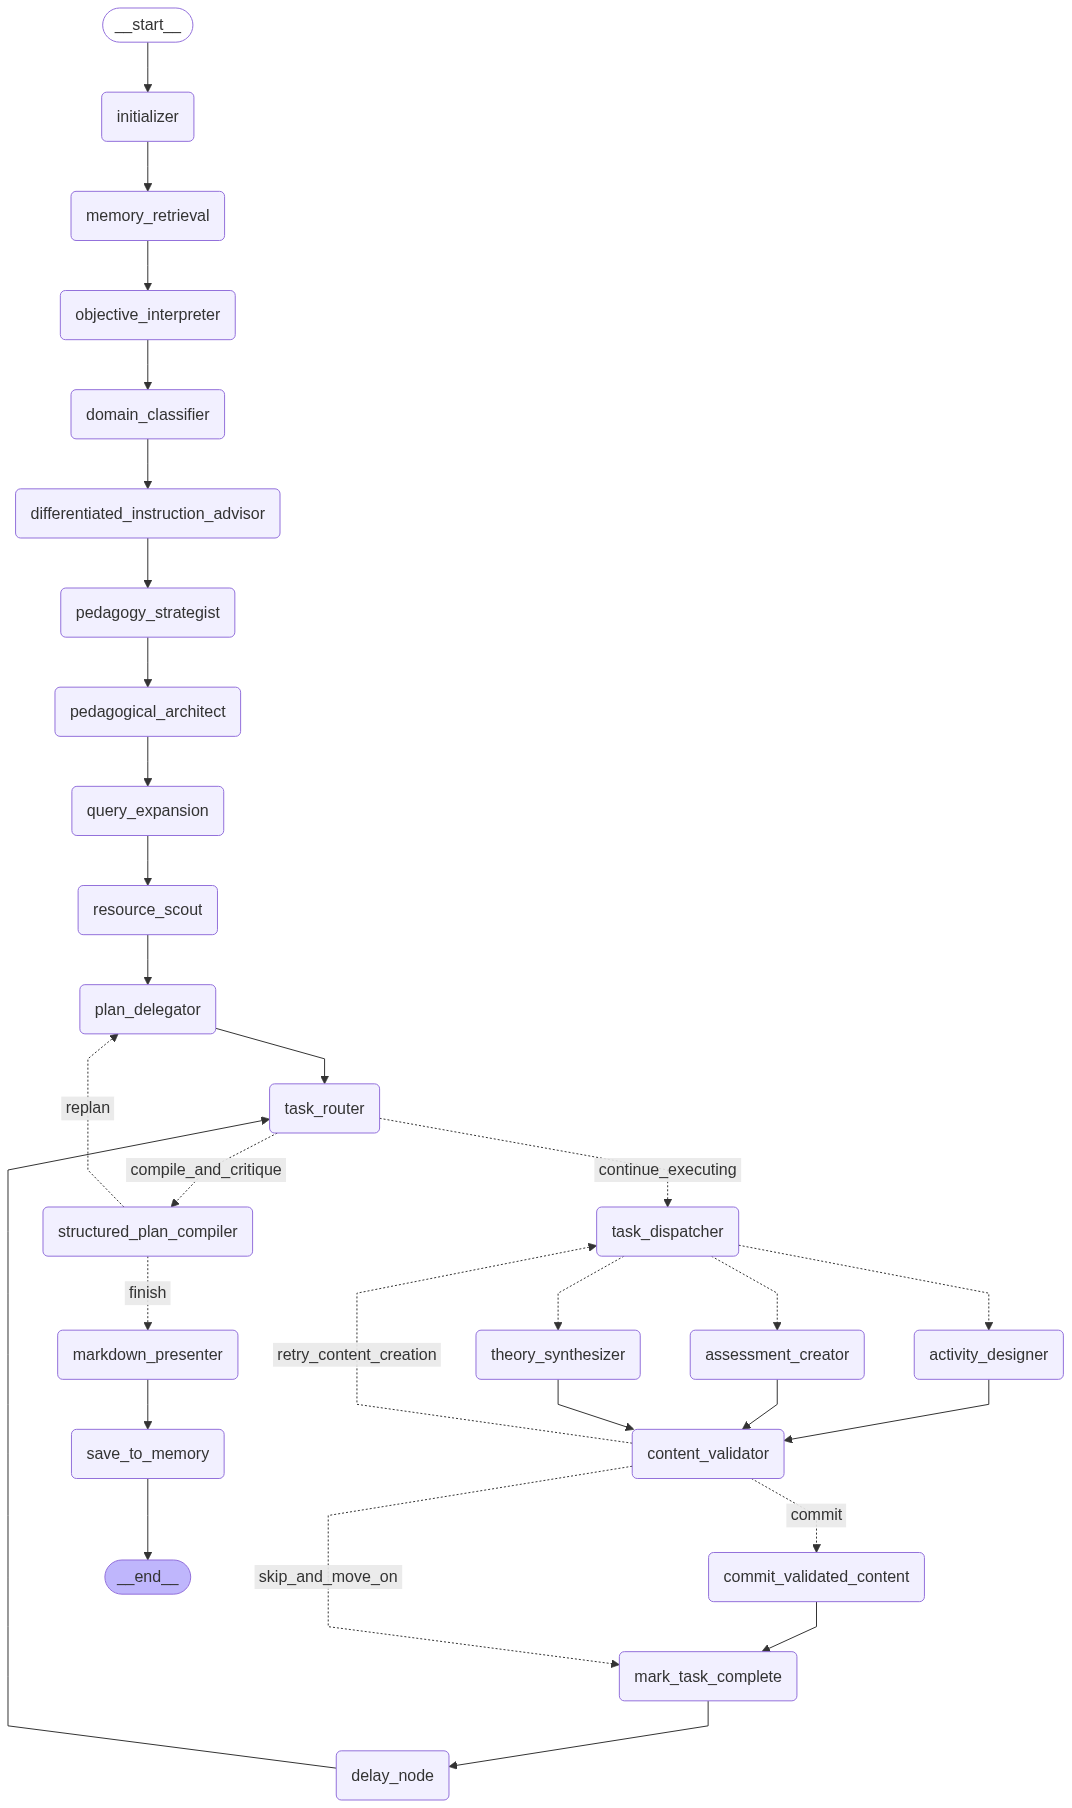

In [36]:
# ==============================================================================
# CELL 4.4: HIỂN THỊ SƠ ĐỒ GRAPH (TÙY CHỌN)
# ==============================================================================
try:
    # Lệnh này sẽ vẽ một sơ đồ của workflow, rất hữu ích để gỡ lỗi
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Lỗi vẽ biểu đồ: {e}. Đây là lỗi không nghiêm trọng, bạn vẫn có thể chạy quy trình.")

## PHẦN 5

In [37]:
# ==============================================================================
# CELL 5.1: ĐỊNH NGHĨA HÀM CHẠY QUY TRÌNH (v12.0 - HOÀN THIỆN)
# ==============================================================================
async def run_architect(user_request: str):
    if 'llm' not in globals() or llm is None:
        print_warning("LLM chưa được khởi tạo.")
        return
    if 'vector_store' not in globals() or vector_store is None:
        print_warning("Kho tri thức chưa được tải.")
        return
    if 'app' not in globals():
        print_warning("Graph 'app' chưa được biên dịch.")
        return

    initial_state = {"messages": [HumanMessage(content=user_request)]}
    console.print(f"\n[bold magenta]🚀 BẮT ĐẦU QUY TRÌNH V12.0 (HOÀN THIỆN) VỚI YÊU CẦU:[/bold magenta]\n> {user_request}")
    config = {"recursion_limit": 150} 
    
    final_markdown_plan = None
    final_structured_plan = None
    
    try:
        async for event in app.astream(initial_state, config=config):
            for node_name, node_output in event.items():
                console.print(f"\n[bold yellow]------- Hoàn thành bước: {node_name} -------[/bold yellow]")
                if node_name == "markdown_presenter":
                    final_markdown_plan = node_output.get("final_markdown_plan")
                    final_structured_plan = node_output.get("final_structured_plan")

        console.print("\n[bold magenta]🏁 KẾT THÚC QUY TRÌNH.[/bold magenta]")
        
        if final_markdown_plan:
            console.print("\n[bold green]📝 GIÁO ÁN HOÀN CHỈNH (v12.0)[/bold green]")
            console.print(Markdown(final_markdown_plan))
            
            if VERBOSE_MODE and final_structured_plan:
                print_result(final_structured_plan, "Output JSON có cấu trúc")
        else:
            print_warning("Không tạo được giáo án cuối cùng. Vui lòng kiểm tra log để gỡ lỗi.")
            
    except Exception as e:
        print_warning(f"Đã xảy ra lỗi nghiêm trọng trong quá trình chạy graph: {e}")
        import traceback
        traceback.print_exc()

print("✅ Hàm `run_architect` (v12.0) đã sẵn sàng để sử dụng.")

✅ Hàm `run_architect` (v12.0) đã sẵn sàng để sử dụng.


In [38]:
# ==============================================================================
# CELL 5.2: KÍCH HOẠT CHẠY THỬ NGHIỆM
# ==============================================================================
# Yêu cầu để kiểm tra
architect_request = "Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao."
VERBOSE_MODE = True 

# Chạy quy trình đã được cải cách
# Lưu ý: bạn cần một môi trường hỗ trợ `await` ở cấp độ cao nhất (như Jupyter Notebook)
await run_architect(architect_request)

🚀 BẮT ĐẦU QUY TRÌNH V12.0 (HOÀN THIỆN) VỚI YÊU CẦU:
> Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là
một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao.

> `Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...

------- Hoàn thành bước: initializer -------

> `Agent: Memory Retrieval` (v9.4) đang tìm kiếm trong trí nhớ...

✔️ Tìm thấy ví dụ tương đồng trong trí nhớ:

"Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao."

------- Hoàn thành bước: memory_retrieval -------

> `Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...

✔️ Mục tiêu & Ràng buộc đã phân tích:

{
│   'action_verb': 'Soạn',
│   'bloom_level': 2,
│   'topic': 'Đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'grade_level': 'Lớp 9',
│   'constraints': {
│   │   'duration_minutes': 90
│   }
}

------- Hoàn thành bước: objective_interpreter -------

> `Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...

✔️ Lĩnh vực chuyên môn được xác định:

'Toán học'

------- Hoàn thành bước: domain_classifier -------

> `Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...

✔️ Hồ sơ lớp học và Chiến lược Phân hóa:

{
│   'learning_pace': 'chậm',
│   'engagement_style': 'thụ động',
│   'special_notes': 'Lớp học có tốc độ tiếp thu chậm, dễ mất tập trung và cần nhiều hoạt động tương tác để duy trì sự chú ý.',
│   'differentiation_strategy': {
│   │   'for_struggling_students': 'Chia nhỏ kiến thức thành các phần dễ hiểu, sử dụng nhiều hình ảnh và mô hình trực quan. Cung cấp phiếu bài tập có gợi ý, công thức mẫu và các bước giải chi tiết. Tổ chức các hoạt động nhóm nhỏ, cho phép học sinh yếu nhận được sự hỗ trợ trực tiếp từ giáo viên và bạn bè. Thường xuyên kiểm tra nhanh để đảm bảo các em theo kịp bài.',
│   │   'for_advanced_students': 'Giao các bài tập mở rộng, yêu cầu chứng minh các tính chất nâng cao hoặc giải các bài toán ứng dụng thực tế. Khuyến khích các em tìm hiểu sâu hơn về mối liên hệ giữa đường tròn và các hình khác. Có thể giao nhiệm vụ hướng dẫn hoặc giải thích cho các bạn trong nhóm (nếu phù hợp).'
│   }
}

------- Hoàn thành bước: differentiated_instruction_advisor -------

> `Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...

✔️ Chiến lược sư phạm chi tiết:

{
│   'name': 'Dạy học hợp tác kết hợp trực quan',
│   'rationale': 'Phương pháp dạy học hợp tác kết hợp sử dụng trực quan rất phù hợp với lớp học có tốc độ tiếp thu chậm, dễ mất tập trung và cần nhiều hoạt động tương tác. Học sinh sẽ được làm việc nhóm, hỗ trợ lẫn nhau, giúp củng cố kiến thức và duy trì sự chú ý. Việc sử dụng đồ dùng trực quan sẽ giúp các em dễ dàng hình dung và nắm bắt các khái niệm hình học trừu tượng. Giáo viên có thể dễ dàng quan sát, hỗ trợ từng nhóm và cá nhân, đồng thời lồng ghép các hoạt động trực quan để tăng cường hiệu quả tiếp thu. Phương pháp này cũng tạo điều kiện tốt để thực hiện chiến lược phân hóa, đảm bảo mọi học sinh đều được học tập theo khả năng của mình.',
│   'key_actions': [
│   │   'Tổ chức nhóm học tập đa dạng: Chia lớp thành các nhóm nhỏ (3-5 học sinh) với sự đa dạng về năng lực để học sinh có thể hỗ trợ lẫn nhau.',
│   │   'Giao nhiệm vụ học tập rõ ràng, có cấu trúc: Cung cấp các phiếu học tập, bài tập nhóm được thiết kế cụ thể, chia nhỏ kiến thức về đường tròn ngoại tiếp và nội tiếp thành các phần dễ hiểu, có gợi ý và ví dụ minh họa.',
│   │   'Sử dụng tối đa đồ dùng trực quan và mô hình: Hướng dẫn học sinh sử dụng compa, thước, ê-ke để vẽ, cắt dán hình, hoặc sử dụng các mô hình tam giác và đường tròn để khám phá tính chất.',
│   │   'Khuyến khích thảo luận và tương tác trong nhóm: Tạo không gian cho học sinh trao đổi, giải thích cho nhau, cùng nhau tìm ra lời giải và chứng minh các tính chất.',
│   │   'Giáo viên đóng vai trò người hỗ trợ và điều phối: Liên tục di chuyển giữa các nhóm, lắng nghe, giải đáp thắc mắc, đưa ra gợi ý kịp thời và kiểm tra nhanh sự tiến bộ của từng nhóm.',
│   │   'Trình bày và chia sẻ kết quả nhóm: Yêu cầu đại diện nhóm trình bày sản phẩm hoặc kết quả thảo luận, giúp củng cố kiến thức và rèn luyện kỹ năng giao tiếp.',
│   │   'Phân hóa bài tập và hỗ trợ cá nhân: Cung cấp các bài tập nâng cao cho học sinh khá giỏi và các bài tập củng cố, có gợi ý chi tiết cho học sinh yếu hơn, đồng thời dành thời gian hỗ trợ riêng cho các em gặp khó khăn.'
│   ]
}

------- Hoàn thành bước: pedagogy_strategist -------

> `Agent: Pedagogical Architect` (v9.4) đang thiết kế kịch bản buổi học...

✔️ Bản thiết kế Sư phạm đã được tạo:

[
│   'Khởi động và Đặt vấn đề: "Vòng tròn kỳ diệu": Giáo viên trình chiếu các hình ảnh/video về các vật thể có hình dạng tam giác và đường tròn trong đời sống (ví dụ: biển báo giao thông, bánh xe, kim tự tháp, logo...). Đặt câu hỏi gợi mở: "Các em thấy hình tam giác và hình tròn xuất hiện ở đâu trong cuộc sống? Chúng có mối liên hệ gì đặc biệt không?". Học sinh suy nghĩ cá nhân và chia sẻ nhanh. Giáo viên dẫn dắt vào việc tìm hiểu mối quan hệ đặc biệt giữa tam giác và đường tròn.',
│   'Khám phá: "Đường tròn ôm trọn tam giác": Chia lớp thành các nhóm nhỏ (3-4 học sinh). Mỗi nhóm được phát một tam giác giấy (hoặc yêu cầu vẽ tam giác bất kỳ), compa, thước. Nhiệm vụ: "Hãy tìm cách vẽ một đường tròn đi qua cả ba đỉnh của tam giác này." Giáo viên gợi ý: "Tâm của đường tròn này có mối liên hệ gì với các cạnh của tam giác?". Các nhóm thảo luận, thử nghiệm, giáo viên đi lại hỗ trợ, gợi ý (ví dụ: "Hãy thử vẽ đường trung trực của các cạnh xem sao?"). Sau đó, đại diện nhóm trình bày kết quả và cách làm. Giáo viên chốt kiến thức về đường tròn ngoại tiếp, tâm là giao điểm 3 đường trung trực, bán kính.',
│   'Khám phá: "Đường tròn nằm gọn trong tam giác": Tiếp tục hoạt động nhóm. Nhiệm vụ: "Bây giờ, hãy tìm cách vẽ một đường tròn tiếp xúc với cả ba cạnh của tam giác này." Giáo viên gợi ý: "Tâm của đường tròn này có mối liên hệ gì với các góc của tam giác?". Các nhóm thảo luận, thử nghiệm. Giáo viên hỗ trợ, gợi ý (ví dụ: "Hãy thử vẽ đường phân giác của các góc xem sao?"). Sau đó, đại diện nhóm trình bày kết quả và cách làm. Giáo viên chốt kiến thức về đường tròn nội tiếp, tâm là giao điểm 3 đường phân giác, bán kính. So sánh sự khác biệt giữa đường tròn ngoại tiếp và nội tiếp.',
│   'Vận dụng: "Thử thách với đường tròn": Giáo viên phát phiếu bài tập gồm các bài tập cơ bản (ví dụ: xác định tâm, bán kính trên hình vẽ cho sẵn; điền vào chỗ trống định nghĩa; phân biệt đường tròn ngoại tiếp/nội tiếp). Học sinh làm việc cá nhân hoặc theo cặp. Giáo viên quan sát, hỗ trợ các em yếu. Sau đó, gọi một vài học sinh lên bảng trình bày hoặc chữa bài nhanh.',
│   'Tổng kết và Liên hệ thực tế: Giáo viên yêu cầu học sinh tóm tắt nhanh những điểm chính đã học về đường tròn ngoại tiếp và nội tiếp. Đặt câu hỏi mở rộng: "Theo các em, kiến thức về đường tròn ngoại tiếp và nội tiếp có thể ứng dụng vào đâu trong thực tế hoặc trong các lĩnh vực khác?". Giáo viên tổng kết, nhấn mạnh các kiến thức quan trọng và giao nhiệm vụ về nhà (nếu có).'
]

------- Hoàn thành bước: pedagogical_architect -------

> `Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...

✔️ Các truy vấn tìm kiếm đã được mở rộng:

[
│   'đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'công thức tính bán kính đường tròn ngoại tiếp',
│   'công thức tính bán kính đường tròn nội tiếp',
│   'bài tập đường tròn ngoại tiếp tam giác',
│   'bài tập đường tròn nội tiếp tam giác',
│   'chuyên đề đường tròn ngoại tiếp nội tiếp lớp 9',
│   'lý thuyết đường tròn ngoại tiếp và nội tiếp',
│   'tâm đường tròn ngoại tiếp và tâm đường tròn nội tiếp',
│   'đường tròn ngoại tiếp tứ giác nội tiếp',
│   'ứng dụng đường tròn ngoại tiếp trong hình học',
│   'các dạng bài tập đường tròn nội tiếp',
│   'ôn thi đường tròn ngoại tiếp nội tiếp',
│   'quan hệ giữa đường tròn ngoại tiếp và nội tiếp',
│   'định lý về đường tròn ngoại tiếp',
│   'định lý về đường tròn nội tiếp'
]

------- Hoàn thành bước: query_expansion -------

> `Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...

> Tìm thấy 75 tài liệu, sàng lọc còn 8 đoạn văn bản độc nhất.

✔️ Tài liệu RAG cuối cùng:

{
│   'source': 'Sách giáo khoa (từ RAG - đã sàng lọc)',
│   'summary': 'Chào các em, với vai trò là một giáo viên giàu kinh nghiệm, thầy/cô sẽ tổng hợp kiến thức cốt lõi về chủ đề "Đường tròn ngoại tiếp và đường tròn nội tiếp" dựa **chỉ** vào các đoạn văn bản mà chúng ta có.\n\n---\n\n**TÓM TẮT KIẾN THỨC CỐT LÕI VỀ ĐƯỜNG TRÒN NGOẠI TIẾP VÀ ĐƯỜNG TRÒN NỘI TIẾP**\n*(Dựa trên các đoạn văn bản được cung cấp)*\n\n**1. Khái niệm cơ bản về Đường tròn**\n\n*   **Định nghĩa:** Đường tròn tâm O bán kính R ($R > 0$), kí hiệu là $(O, R)$, là hình gồm tất cả các điểm cách điểm O một khoảng bằng R. Khi không cần để ý đến bán kính, kí hiệu là (O).\n*   **Điểm thuộc đường tròn:** Điểm A thuộc đường tròn (O) nếu $A \\in (O)$, hay đường tròn (O) đi qua điểm A, hoặc điểm A nằm trên đường tròn (O).\n*   **Vị trí tương đối của điểm M và đường tròn (O; R):**\n    *   Điểm M nằm trên đường tròn nếu $OM = R$.\n    *   Điểm M nằm trong đường tròn nếu $OM < R$.\n    *   Điểm M nằm ngoài đường tròn nếu $OM > R$.\n*   **Hình tròn:** Hình tròn tâm O bán kính R là hình gồm các điểm nằm trên và nằm trong đường tròn (O; R).\n*   **Tính đối xứng của đường tròn:** Đường tròn có tâm đối xứng (là tâm O) và trục đối xứng (là bất kỳ đường thẳng nào đi qua tâm O). Đường trung trực của một đoạn thẳng nối hai điểm thuộc đường tròn cũng là một trục đối xứng của đường tròn đó.\n\n**2. Đường tròn đi qua các đỉnh của đa giác (Khái niệm liên quan đến Đường tròn ngoại tiếp)**\n\nMặc dù các đoạn văn bản không định nghĩa trực tiếp "đường tròn ngoại tiếp", nhưng các bài tập đã đề cập đến trường hợp một đường tròn đi qua các đỉnh của một đa giác, đây chính là bản chất của đường tròn ngoại tiếp.\n\n*   **Đối với tam giác vuông:**\n    *   Các điểm A, B, C của một tam giác vuông có thể thuộc cùng một đường tròn. (Ví dụ: Bài 5.2 yêu cầu chứng minh các đỉnh của tam giác vuông thuộc cùng một đường tròn và tính bán kính của nó).\n*   **Đối với hình vuông:**\n    *   Có một đường tròn đi qua bốn đỉnh của hình vuông.\n    *   Tâm của đường tròn này là giao điểm của hai đường chéo của hình vuông.\n    *   Đường tròn này có tâm đối xứng và các trục đối xứng. (Ví dụ: Bài 5.4 yêu cầu chứng minh có đường tròn đi qua bốn đỉnh hình vuông và xác định tâm, trục đối xứng của nó).\n\n**3. Đường tròn nội tiếp**\n\n*   Các đoạn văn bản được cung cấp **không chứa thông tin** về khái niệm hay tính chất của đường tròn nội tiếp.\n\n---'
}

------- Hoàn thành bước: resource_scout -------

> `Agent: Headmaster Delegator` (v12.6 - Giao việc Cụ thể) đang chỉ đạo...

✔️ Đã tạo 5 nhiệm vụ với chỉ dẫn chi tiết:

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động và Gợi mở vấn đề về mối liên hệ giữa tam giác và đường tròn',
│   │   'task_description': 'Giáo viên trình chiếu các hình ảnh/video về các vật thể có hình dạng tam giác và đường tròn trong đời sống (ví dụ: biển báo giao thông, bánh xe, kim tự tháp, logo...). Đặt câu hỏi gợi mở: "Các em thấy hình tam giác và hình tròn xuất hiện ở đâu trong cuộc sống? Chúng có mối liên hệ gì đặc biệt không?". Học sinh suy nghĩ cá nhân và chia sẻ nhanh. Giáo viên dẫn dắt vào việc tìm hiểu mối quan hệ đặc biệt giữa tam giác và đường tròn.',
│   │   'estimated_duration': 15,
│   │   'guidance': 'Chỉ tập trung vào việc kích thích tư duy và tạo hứng thú ban đầu, không đi sâu vào kiến thức mới.',
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá Đường tròn ngoại tiếp tam giác',
│   │   'task_description': 'Chia lớp thành các nhóm nhỏ (3-4 học sinh). Mỗi nhóm được phát một tam giác giấy (hoặc yêu cầu vẽ tam giác bất kỳ), compa, thước. Nhiệm vụ: "Hãy tìm cách vẽ một đường tròn đi qua cả ba đỉnh của tam giác này." Giáo viên gợi ý: "Tâm của đường tròn này có mối liên hệ gì với các cạnh của tam giác?". Các nhóm thảo luận, thử nghiệm. Giáo viên đi lại hỗ trợ, gợi ý (ví dụ: "Hãy thử vẽ đường trung trực của các cạnh xem sao?"). Sau đó, đại diện nhóm trình bày kết quả và cách làm. Giáo viên chốt kiến thức về đường tròn ngoại tiếp, tâm là giao điểm 3 đường trung trực, bán kính.',
│   │   'estimated_duration': 25,
│   │   'guidance': 'Đảm bảo học sinh tự khám phá ra cách vẽ và xác định tâm đường tròn ngoại tiếp thông qua đường trung trực, không giảng giải trước.',
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Khám phá Đường tròn nội tiếp tam giác',
│   │   'task_description': 'Tiếp tục hoạt động nhóm. Nhiệm vụ: "Bây giờ, hãy tìm cách vẽ một đường tròn tiếp xúc với cả ba cạnh của tam giác này." Giáo viên gợi ý: "Tâm của đường tròn này có mối liên hệ gì với các góc của tam giác?". Các nhóm thảo luận, thử nghiệm. Giáo viên hỗ trợ, gợi ý (ví dụ: "Hãy thử vẽ đường phân giác của các góc xem sao?"). Sau đó, đại diện nhóm trình bày kết quả và cách làm. Giáo viên chốt kiến thức về đường tròn nội tiếp, tâm là giao điểm 3 đường phân giác, bán kính. So sánh sự khác biệt giữa đường tròn ngoại tiếp và nội tiếp.',
│   │   'estimated_duration': 25,
│   │   'guidance': 'Tập trung vào việc học sinh tự tìm ra cách vẽ và xác định tâm đường tròn nội tiếp thông qua đường phân giác, đồng thời so sánh hai loại đường tròn.',
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Vận dụng kiến thức về đường tròn ngoại tiếp và nội tiếp',
│   │   'task_description': 'Giáo viên phát phiếu bài tập gồm các bài tập cơ bản (ví dụ: xác định tâm, bán kính trên hình vẽ cho sẵn; điền vào chỗ trống định nghĩa; phân biệt đường tròn ngoại tiếp/nội tiếp). Học sinh làm việc cá nhân hoặc theo cặp. Giáo viên quan sát, hỗ trợ các em yếu. Sau đó, gọi một vài học sinh lên bảng trình bày hoặc chữa bài nhanh.',
│   │   'estimated_duration': 15,
│   │   'guidance': 'Chỉ tập trung vào các bài tập cơ bản, giúp học sinh củng cố định nghĩa và cách nhận biết, không đi sâu vào bài tập phức tạp.',
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Tổng kết kiến thức và Liên hệ thực tế',
│   │   'task_description': 'Giáo viên yêu cầu học sinh tóm tắt nhanh những điểm chính đã học về đường tròn ngoại tiếp và nội tiếp. Đặt câu hỏi mở rộng: "Theo các em, kiến thức về đường tròn ngoại tiếp và nội tiếp có thể ứng dụng vào đâu trong thực tế hoặc trong các lĩnh vực khác?". Giáo viên tổng kết, nhấn mạnh các kiến thức quan trọng và giao nhiệm vụ về nhà (nếu có).',
│   │   'estimated_duration': 10,
│   │   'guidance': 'Đảm bảo học sinh tự tổng hợp kiến thức và liên hệ được với thực tế, không giảng lại toàn bộ bài học.',
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động và Gợi mở vấn đề về mối liên hệ giữa tam giác và đường tròn' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Assessment Creator tạo ra:

{
│   'activity_name': 'Khởi động: Tam giác và Đường tròn có gì chung?',
│   'duration_minutes': 15,
│   'teacher_actions': [
│   │   'Chuẩn bị các hình ảnh/vật thể minh họa có chứa cả tam giác và đường tròn.',
│   │   'Chiếu hình ảnh và đặt câu hỏi gợi mở cho cả lớp.',
│   │   'Chia nhóm và hướng dẫn học sinh thảo luận trong 5 phút.',
│   │   'Đi lại các nhóm lắng nghe, gợi ý (nếu cần) và khuyến khích tất cả học sinh tham gia.',
│   │   'Mời đại diện 2-3 nhóm chia sẻ ý kiến của nhóm mình (mỗi nhóm 2-3 phút).',
│   │   'Tổng hợp các ý kiến, không đánh giá đúng sai mà chỉ ghi nhận và tạo không khí tò mò, hứng thú cho bài học mới.'
│   ],
│   'extension_component': 'Nếu còn thời gian, yêu cầu các nhóm tìm thêm ví dụ khác trong đời sống hoặc tự vẽ một hình kết hợp tam giác và đường tròn mà họ thấy thú vị.',
│   'answer': 'Học sinh có thể đưa ra nhiều ý tưởng khác nhau, ví dụ: đường tròn ngoại tiếp/nội tiếp tam giác, tam giác nội tiếp/ngoại tiếp đường tròn, các điểm đặc biệt của tam giác liên quan đến đường tròn (tâm đường tròn ngoại tiếp, nội tiếp), hoặc đơn giản là sự xuất hiện cùng nhau trong một vật thể/hình ảnh.',
│   'solution_guide': None,
│   'differentiation': {
│   │   'for_struggling_students': "GV có thể gợi ý bằng cách khoanh tròn hoặc chỉ rõ các hình tam giác và đường tròn trong ảnh, đặt câu hỏi cụ thể hơn như 'Hình tròn này có đi qua đỉnh nào của tam giác không?' hoặc 'Tam giác này có nằm bên trong hình tròn không?'",
│   │   'for_advanced_students': 'Yêu cầu học sinh suy nghĩ về các tính chất hình học mà tam giác và đường tròn có thể chia sẻ hoặc ảnh hưởng lẫn nhau (ví dụ: đối xứng, tâm, bán kính, góc...).'
│   },
│   'question_or_description': "GV chiếu một số hình ảnh/vật thể quen thuộc có chứa cả hình tam giác và hình tròn (ví dụ: bánh xe đạp, kim tự tháp nhìn từ trên xuống, logo, kiến trúc...). Yêu cầu học sinh quan sát và thảo luận nhóm 3-4 người trong 5 phút để trả lời câu hỏi: 'Các em có nhận thấy mối liên hệ nào giữa hình tam giác và hình tròn trong các hình ảnh này không? Hãy chia sẻ những suy nghĩ ban đầu của mình.'",
│   'content_type': 'Thảo luận nhóm/Tự luận ngắn'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng. Hãy giảm số lượng nhóm chia sẻ và giới hạn thời gian chia sẻ của
mỗi nhóm xuống còn tối đa 1 phút để đảm bảo thời gian.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Theory Synthesizer tạo ra:

{
│   'activity_name': 'Khởi động: Tam giác và Đường tròn',
│   'duration_minutes': 15,
│   'teacher_actions': [
│   │   'Chiếu các hình ảnh đa dạng về tam giác và đường tròn có mối liên hệ với nhau.',
│   │   "Đặt câu hỏi gợi mở: 'Các em quan sát thấy gì trong các hình này?', 'Tam giác và đường tròn có mối liên hệ như thế nào với nhau?'.",
│   │   'Yêu cầu học sinh suy nghĩ cá nhân và ghi chú nhanh các ý tưởng.',
│   │   'Tổ chức cho học sinh thảo luận nhóm nhỏ (2-3 em) để chia sẻ và tổng hợp các quan sát.',
│   │   'Mời đại diện một vài nhóm chia sẻ ý kiến trước lớp, khuyến khích các ý tưởng đa dạng.',
│   │   'Tổng hợp các ý kiến, nhấn mạnh rằng có nhiều cách mà tam giác và đường tròn có thể liên hệ với nhau, tạo tiền đề cho bài học mới mà không đi sâu vào định nghĩa.'
│   ],
│   'extension_component': 'Nếu còn thời gian, yêu cầu học sinh thử vẽ một tam giác và một đường tròn sao cho chúng có một mối liên hệ đặc biệt nào đó mà các em tự nghĩ ra.',
│   'solution_guide': 'Gợi ý: Học sinh có thể nhận ra các mối liên hệ như đường tròn ngoại tiếp tam giác (đi qua 3 đỉnh), đường tròn nội tiếp tam giác (tiếp xúc 3 cạnh), hoặc các trường hợp khác như đường tròn đi qua trung điểm các cạnh, đường tròn bàng tiếp, v.v. Giáo viên nên chấp nhận mọi quan sát hợp lý và không yêu cầu câu trả lời chính xác về mặt định nghĩa, chỉ tập trung vào việc kích thích tư duy và sự tò mò.',
│   'differentiation': {
│   │   'for_struggling_students': 'Gợi ý học sinh tập trung vào việc nhận diện các điểm chung đơn giản nhất: đường tròn đi qua đỉnh tam giác, hoặc đường tròn tiếp xúc với cạnh tam giác.',
│   │   'for_advanced_students': 'Khuyến khích học sinh suy nghĩ về các trường hợp đặc biệt của tam giác (ví dụ: tam giác đều, tam giác vuông) khi có mối liên hệ với đường tròn, hoặc các vị trí tương đối khác.'
│   },
│   'question_or_description': 'Giáo viên chiếu các hình ảnh minh họa về mối liên hệ giữa tam giác và đường tròn (ví dụ: tam giác nội tiếp đường tròn, đường tròn nội tiếp tam giác, đường tròn đi qua các đỉnh/trung điểm của tam giác). Học sinh quan sát, suy nghĩ cá nhân trong 2 phút, sau đó thảo luận nhóm 3-4 phút để chia sẻ những gì các em nhìn thấy và mối liên hệ ban đầu giữa hai hình này. Mục tiêu là kích thích sự tò mò và gợi mở vấn đề.',
│   'content_type': 'Thảo luận nhóm nhỏ'
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng. Hãy LOẠI BỎ hoàn toàn trường "extension_component" và 
"differentiation" để tiết kiệm thời gian.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Assessment Creator tạo ra:

{
│   'activity_name': 'Khởi động: Tam giác và Đường tròn có gì chung?',
│   'duration_minutes': 15,
│   'teacher_actions': [
│   │   'Chuẩn bị các hình ảnh/vật thể minh họa đa dạng.',
│   │   'Chiếu hình ảnh và đặt câu hỏi gợi mở cho cả lớp.',
│   │   'Tổ chức cho học sinh thảo luận nhóm nhỏ (3-4 học sinh) trong 3-5 phút.',
│   │   'Mời đại diện 2-3 nhóm trình bày ý kiến của nhóm mình.',
│   │   'Tổng hợp các ý kiến, khen ngợi sự sáng tạo và dẫn dắt vào bài học mới một cách tự nhiên.'
│   ],
│   'extension_component': 'Nếu còn thời gian, yêu cầu học sinh vẽ nhanh một hình ảnh bất kỳ mà trong đó có sự kết hợp của cả tam giác và đường tròn, sau đó chia sẻ ý tưởng của mình với bạn bên cạnh.',
│   'answer': 'Học sinh có thể nêu các mối liên hệ như: tam giác nằm trong đường tròn (nội tiếp), đường tròn nằm trong tam giác (ngoại tiếp), chúng cùng xuất hiện trong một vật thể, được dùng để tạo hình, thiết kế...',
│   'solution_guide': None,
│   'differentiation': {
│   │   'for_struggling_students': "GV có thể gợi ý bằng cách đặt câu hỏi cụ thể hơn cho từng hình ảnh: 'Trong hình này, con thấy hình tròn nằm ở đâu so với tam giác?' hoặc 'Hình tam giác này có đặc điểm gì đặc biệt liên quan đến đường tròn không?'",
│   │   'for_advanced_students': 'Yêu cầu học sinh suy nghĩ về các ứng dụng thực tế hoặc trong kiến trúc, nghệ thuật mà tam giác và đường tròn cùng xuất hiện và có vai trò quan trọng, hoặc nêu ví dụ khác ngoài các hình ảnh đã cho.'
│   },
│   'question_or_description': "GV chiếu một số hình ảnh/vật thể quen thuộc có chứa cả hình tam giác và hình tròn (ví dụ: bánh xe đạp, kim tự tháp nhìn từ trên xuống, logo...). Yêu cầu học sinh quan sát, thảo luận nhóm (3-5 phút) và chia sẻ: 'Các con thấy mối liên hệ nào giữa hình tam giác và hình tròn trong các hình ảnh này?'",
│   'content_type': 'Thảo luận nhóm/Tự luận ngắn'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng. Để đảm bảo thời gian 15 phút, hãy giảm số lượng nhóm trình bày 
xuống còn 1 nhóm hoặc thay bằng hình thức chia sẻ nhanh cả lớp.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khởi động: Tam giác và Đường tròn quanh ta',
│   'duration_minutes': 15,
│   'teacher_actions': [
│   │   'Chuẩn bị và chiếu các hình ảnh/video minh họa đa dạng.',
│   │   "Đặt câu hỏi gợi mở: 'Các em có nhận xét gì về mối liên hệ giữa tam giác và đường tròn trong các hình ảnh này? Chúng có thể 'gắn' vào nhau như thế nào?'",
│   │   'Quan sát, lắng nghe các nhóm thảo luận và hỗ trợ khi cần.',
│   │   'Gọi một vài học sinh/đại diện nhóm chia sẻ ý kiến ban đầu.',
│   │   'Tổng hợp nhanh các ý kiến của học sinh, nhấn mạnh đây là hoạt động gợi mở, chưa đi sâu vào kiến thức mới.'
│   ],
│   'extension_component': 'Nếu còn thời gian, học sinh có thể thử vẽ nhanh một hình bất kỳ mà trong đó có cả tam giác và đường tròn, thể hiện một mối liên hệ nào đó giữa chúng.',
│   'solution_guide': 'Các câu hỏi gợi mở cho học sinh: Tam giác có thể nằm hoàn toàn bên trong đường tròn không? Ngược lại thì sao? Có trường hợp nào đường tròn đi qua các đỉnh của tam giác, hoặc tiếp xúc với các cạnh của tam giác không?',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp các hình ảnh đơn giản, rõ ràng hơn, hoặc gợi ý cụ thể hơn về vị trí của tam giác và đường tròn trong hình để học sinh dễ nhận diện và liên hệ.',
│   │   'for_advanced_students': "Yêu cầu các em suy nghĩ về các trường hợp đặc biệt của tam giác (đều, vuông, cân) khi nó 'gắn' với đường tròn, hoặc các vị trí tương đối khác nhau mà chúng có thể có."
│   },
│   'question_or_description': 'Giáo viên chiếu một số hình ảnh/video về các vật thể, kiến trúc, hoặc hình vẽ có sự xuất hiện của cả tam giác và đường tròn (ví dụ: bánh xe đạp, kim tự tháp nhìn từ trên xuống, logo, các hình vẽ hình học cơ bản). Học sinh quan sát, nhận diện các hình tam giác và đường tròn trong mỗi hình ảnh. Sau đó, học sinh thảo luận nhóm 2-3 người (hoặc cá nhân) để đưa ra nhận xét ban đầu về mối liên hệ giữa tam giác và đường tròn trong các hình ảnh đó. Đại diện một vài nhóm/cá nhân chia sẻ ý kiến.',
│   'content_type': 'Thảo luận nhóm nhỏ và chia sẻ chung'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng cho 15 phút. Hãy **LOẠI BỎ hoàn toàn trường `extension_component`
và `differentiation`** để đảm bảo thời gian.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khởi động: Tam giác và Đường tròn trong cuộc sống',
│   'duration_minutes': 15,
│   'teacher_actions': [
│   │   'Chiếu các hình ảnh minh họa về tam giác và đường tròn trong thực tế.',
│   │   'Nêu câu hỏi gợi mở và hướng dẫn học sinh thảo luận nhóm.',
│   │   'Quan sát, lắng nghe các nhóm thảo luận và hỗ trợ khi cần.',
│   │   'Mời 2-3 học sinh đại diện chia sẻ ý kiến ban đầu của nhóm/cá nhân.',
│   │   'Tổng hợp nhanh các ý kiến, nhấn mạnh sự đa dạng trong quan sát và suy nghĩ, không đánh giá đúng sai hay đi sâu vào kiến thức mới.'
│   ],
│   'extension_component': 'Nếu còn thời gian, học sinh có thể vẽ nhanh một hình ảnh khác mà họ nghĩ có sự kết hợp giữa tam giác và đường tròn trong cuộc sống hoặc trong các môn học khác.',
│   'solution_guide': 'Các câu hỏi gợi mở cho giáo viên khi tổng hợp: "Tam giác có nằm trong đường tròn không?", "Đường tròn có nằm trong tam giác không?", "Các đỉnh/cạnh của tam giác có mối quan hệ gì với đường tròn?", "Các em đã từng thấy hình ảnh nào tương tự trong cuộc sống chưa?"',
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể gợi ý cụ thể hơn về các chi tiết trong hình ảnh (ví dụ: "Hãy nhìn vào các cạnh của tam giác, chúng có chạm vào đường tròn không?", "Đỉnh của tam giác nằm ở đâu so với đường tròn?").',
│   │   'for_advanced_students': 'Yêu cầu học sinh suy nghĩ về các tính chất hình học cơ bản của tam giác và đường tròn mà họ đã biết, và liệu chúng có thể liên quan đến nhau như thế nào trong các hình ảnh.'
│   },
│   'question_or_description': 'Giáo viên chiếu một số hình ảnh/ví dụ thực tế có sự xuất hiện đồng thời của tam giác và đường tròn (ví dụ: bánh xe đạp, logo, kiến trúc, đồ vật...). Học sinh quan sát các hình ảnh và thảo luận nhóm (2-3 HS) trong 5-7 phút để trả lời câu hỏi: "Các em có nhận thấy mối liên hệ nào giữa tam giác và đường tròn trong các hình ảnh này không? Hãy chia sẻ những gì các em thấy hoặc suy nghĩ."',
│   'content_type': 'Thảo luận nhóm nhỏ và chia sẻ'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng. Để đảm bảo tính khả thi trong 15 phút, hãy **GIẢM thời gian thảo
luận nhóm xuống còn 3-4 phút**.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Assessment Creator tạo ra:

{
│   'activity_name': 'Khởi động: Khám phá mối liên hệ Tam giác và Đường tròn',
│   'duration_minutes': 15,
│   'teacher_actions': [
│   │   'Giới thiệu hoạt động và mục tiêu: kích thích tư duy về mối liên hệ giữa tam giác và đường tròn.',
│   │   'Yêu cầu học sinh suy nghĩ cá nhân hoặc thảo luận nhóm nhỏ (2-3 phút).',
│   │   'Mời một vài học sinh/đại diện nhóm chia sẻ ý tưởng, giáo viên ghi nhận các ý tưởng chính lên bảng (5-7 phút).',
│   │   'Dẫn dắt, tổng hợp các ý tưởng và gợi mở về bài học sắp tới mà không đi sâu vào kiến thức mới (3-5 phút).'
│   ],
│   'extension_component': 'Nếu có thể, em hãy thử nghĩ xem mối liên hệ này có ý nghĩa gì trong việc giải quyết các bài toán hình học hoặc trong các ứng dụng thực tế khác?',
│   'answer': 'Học sinh có thể đưa ra các ví dụ về hình ảnh thực tế (biển báo giao thông, bánh xe đạp, kim tự tháp nhìn từ trên xuống,...) hoặc các ý tưởng về vị trí tương đối (tam giác nội tiếp/ngoại tiếp đường tròn, đường tròn nội tiếp/ngoại tiếp tam giác - dù chưa học nhưng có thể hình dung).',
│   'solution_guide': None,
│   'differentiation': {
│   │   'for_struggling_students': 'Gợi ý các vật thể quen thuộc có cả hai hình (ví dụ: bánh xe đạp, biển báo giao thông, kim tự tháp nhìn từ trên xuống). Yêu cầu chỉ cần mô tả đơn giản hoặc vẽ phác thảo.',
│   │   'for_advanced_students': "Yêu cầu học sinh suy nghĩ về các khái niệm toán học (dù chưa học) như 'nội tiếp', 'ngoại tiếp' hoặc các tính chất hình học có thể liên quan đến sự 'gặp nhau' của hai hình."
│   },
│   'question_or_description': "Hãy suy nghĩ và chia sẻ những ý tưởng của em về việc hình tam giác và hình tròn có thể 'gặp nhau' hoặc có mối liên hệ với nhau trong toán học hoặc trong cuộc sống hàng ngày. Em có thể vẽ minh họa hoặc mô tả bằng lời.",
│   'content_type': 'Tự luận/Thảo luận'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng cho 15 phút. Hãy LOẠI BỎ hoàn toàn trường "extension_component" và
"differentiation" để tập trung vào phần khởi động chính.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khởi động: Tam giác và Đường tròn trong cuộc sống',
│   'duration_minutes': 15,
│   'teacher_actions': [
│   │   'Chiếu các hình ảnh/video gợi mở về tam giác và đường tròn.',
│   │   'Nêu câu hỏi định hướng cho hoạt động thảo luận nhóm.',
│   │   'Đi quanh lớp, quan sát và lắng nghe các nhóm thảo luận, gợi ý nếu cần (nhưng không cung cấp kiến thức mới).',
│   │   'Mời đại diện các nhóm chia sẻ ý kiến.',
│   │   'Tổng hợp các ý kiến đa dạng của học sinh, khen ngợi những phát hiện thú vị và dẫn dắt vào bài học mới một cách tự nhiên.'
│   ],
│   'extension_component': 'Nếu còn thời gian, các nhóm có thể vẽ nhanh một hình ảnh khác mà các em nghĩ ra có sự kết hợp giữa tam giác và đường tròn, hoặc đặt một câu hỏi về mối liên hệ giữa chúng mà các em muốn tìm hiểu trong bài học sắp tới.',
│   'solution_guide': "Các câu hỏi gợi mở cho giáo viên khi tổng kết: 'Có phải lúc nào tam giác cũng nằm trong đường tròn không?', 'Đường tròn có thể đi qua mấy đỉnh của một tam giác bất kỳ?', 'Có loại tam giác đặc biệt nào mà chúng ta thường thấy liên quan đến đường tròn không?' (ví dụ: tam giác vuông nội tiếp đường tròn).",
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể gợi ý cụ thể hơn về các vật thể quen thuộc trong đời sống hàng ngày (ví dụ: đồng hồ, la bàn, biển báo giao thông) để học sinh dễ dàng liên hệ và tìm ra mối liên hệ đơn giản nhất.',
│   │   'for_advanced_students': "Yêu cầu học sinh suy nghĩ sâu hơn về các tính chất hình học cơ bản của tam giác và đường tròn mà các em đã biết, và liệu chúng có thể 'tương tác' với nhau như thế nào trong các hình ảnh đã cho (ví dụ: đường tròn đi qua các đỉnh của tam giác, tam giác nội tiếp/ngoại tiếp đường tròn)."
│   },
│   'question_or_description': "Giáo viên chiếu một số hình ảnh/video ngắn về các vật thể, kiến trúc, hoặc hiện tượng tự nhiên có sự xuất hiện đồng thời của hình tam giác và đường tròn (ví dụ: bánh xe đạp, kim tự tháp nhìn từ trên xuống, logo, cầu vòm, mặt cắt ngang của thân cây). Học sinh quan sát, suy nghĩ cá nhân trong 2 phút. Sau đó, học sinh thảo luận nhóm (3-4 người) trong 7 phút để trả lời các câu hỏi: 'Các em thấy hình tam giác và đường tròn xuất hiện cùng nhau ở đâu trong các hình ảnh này?', 'Các em có nhận ra mối liên hệ nào giữa chúng không?'. Cuối cùng, mời 2-3 nhóm chia sẻ nhanh ý kiến của mình.",
│   'content_type': 'Thảo luận nhóm nhỏ và Chia sẻ'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng cho 15 phút. Hãy GIẢM thời gian thảo luận nhóm xuống còn 5 phút.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khởi động: Mối liên hệ giữa Tam giác và Đường tròn',
│   'duration_minutes': 15,
│   'teacher_actions': [
│   │   'Chuẩn bị và trình chiếu các hình ảnh minh họa đa dạng về mối liên hệ giữa tam giác và đường tròn.',
│   │   'Hướng dẫn học sinh quan sát cá nhân và thảo luận cặp đôi.',
│   │   "Đi lại các nhóm, lắng nghe và đặt câu hỏi gợi mở để kích thích tư duy (ví dụ: 'Điều gì đặc biệt về vị trí của tam giác so với đường tròn trong hình này?').",
│   │   "Mời đại diện một số cặp đôi chia sẻ ý kiến, ghi nhận các từ khóa/mối liên hệ mà học sinh nêu ra lên bảng (ví dụ: 'nằm trong', 'nằm ngoài', 'tiếp xúc', 'đi qua đỉnh', 'chứa').",
│   │   "Tổng hợp các ý kiến và dẫn dắt vào bài học mới: 'Vậy theo các em, tam giác và đường tròn có thể có những mối liên hệ nào? Chúng ta sẽ cùng tìm hiểu sâu hơn trong bài học hôm nay'."
│   ],
│   'extension_component': 'Nếu còn thời gian, học sinh có thể thử vẽ nhanh một hình tam giác và một đường tròn có mối liên hệ đặc biệt mà các em tự nghĩ ra, hoặc tìm kiếm thêm ví dụ về mối liên hệ này trong thực tế (ví dụ: logo, kiến trúc, đồ vật).',
│   'solution_guide': None,
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp các hình ảnh đơn giản hơn, có chú thích rõ ràng về các hình cơ bản. Gợi ý các câu hỏi cụ thể hơn như 'Hình tam giác này nằm ở đâu so với đường tròn?' hoặc 'Đường tròn này đi qua những điểm nào của tam giác?'.",
│   │   'for_advanced_students': "Khuyến khích học sinh suy nghĩ về các trường hợp đặc biệt (ví dụ: tam giác đều nội tiếp/ngoại tiếp đường tròn) hoặc đặt câu hỏi về tính chất của các mối liên hệ đó (ví dụ: 'Liệu có phải lúc nào cũng vẽ được một đường tròn đi qua 3 đỉnh của một tam giác không?')."
│   },
│   'question_or_description': "Giáo viên trình chiếu các hình ảnh minh họa đa dạng về mối liên hệ giữa tam giác và đường tròn (ví dụ: tam giác nội tiếp đường tròn, đường tròn nội tiếp tam giác, tam giác có các đỉnh nằm trên đường tròn, đường tròn tiếp xúc với các cạnh của tam giác). Học sinh quan sát cá nhân trong 3 phút, sau đó thảo luận cặp đôi trong 5 phút để trả lời các câu hỏi: 'Các em thấy những hình nào trong ảnh?', 'Có mối liên hệ nào giữa tam giác và đường tròn trong các hình này không? Hãy mô tả mối liên hệ đó.', 'Các em có thắc mắc gì về mối liên hệ này không?'.",
│   'content_type': 'Hoạt động cá nhân và chia sẻ'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng. Hãy **giới hạn phần chia sẻ ý kiến học sinh chỉ còn 1-2 cặp đôi 
và tổng hợp nhanh gọn** để đảm bảo thời gian.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khởi động: Tam giác và Đường tròn trong cuộc sống',
│   'duration_minutes': 15,
│   'teacher_actions': [
│   │   'Chiếu các hình ảnh/ví dụ minh họa đa dạng.',
│   │   'Phát phiếu ghi chú nhanh hoặc yêu cầu học sinh ghi ý tưởng vào vở.',
│   │   "Quan sát, lắng nghe các nhóm thảo luận, đặt câu hỏi gợi mở (ví dụ: 'Hình tam giác có đặc điểm gì?', 'Hình tròn có đặc điểm gì?', 'Chúng có giúp ích gì cho nhau không?').",
│   │   'Mời đại diện các nhóm chia sẻ ý kiến, khuyến khích sự đa dạng trong câu trả lời.',
│   │   'Tổng hợp các ý kiến chính, dẫn dắt vào bài học mới mà không đi sâu vào kiến thức.'
│   ],
│   'extension_component': 'Nếu còn thời gian, học sinh có thể vẽ nhanh một hình ảnh/thiết kế đơn giản của riêng mình có sử dụng cả tam giác và đường tròn, sau đó giải thích ý tưởng của mình.',
│   'solution_guide': 'Gợi ý các câu trả lời mong đợi từ học sinh: nhận diện được các hình tam giác và đường tròn, nhận thấy sự lồng ghép/tiếp xúc/cắt nhau giữa chúng, suy đoán về ứng dụng (ví dụ: tạo sự ổn định, thẩm mỹ, tối ưu không gian, chuyển động). Mục tiêu là kích thích sự tò mò và liên tưởng, không yêu cầu câu trả lời chính xác về mặt toán học.',
│   'differentiation': {
│   │   'for_struggling_students': "Giáo viên có thể chỉ rõ từng hình tam giác và đường tròn trong ảnh, hoặc đặt câu hỏi cụ thể hơn như 'Hình này có mấy tam giác? Mấy đường tròn?'.",
│   │   'for_advanced_students': 'Yêu cầu học sinh suy nghĩ về các tính chất hình học cơ bản của tam giác và đường tròn mà họ đã biết, và liệu chúng có thể liên quan đến nhau như thế nào trong các ví dụ đã cho (ví dụ: tính đối xứng của đường tròn, tính ổn định của tam giác).'
│   },
│   'question_or_description': "Giáo viên chiếu một số hình ảnh/ví dụ thực tế (ví dụ: bánh xe đạp, logo, kiến trúc, đồ vật trang trí) có chứa cả hình tam giác và hình tròn. Học sinh quan sát, thảo luận nhóm (2-3 em) trong 5 phút để trả lời các câu hỏi: 'Các em nhìn thấy những hình nào trong bức ảnh này?', 'Có mối liên hệ nào giữa tam giác và đường tròn trong các hình này không?', 'Theo các em, tại sao người ta lại sử dụng cả hai hình này cùng lúc trong thiết kế/cấu trúc?'. Sau đó, đại diện một vài nhóm chia sẻ ý kiến trước lớp.",
│   'content_type': 'Thảo luận nhóm nhỏ và chia sẻ'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng cho 15 phút. Hãy **LOẠI BỎ hoàn toàn trường "extension_component"
và "differentiation"** để tập trung vào mục tiêu khởi động chính.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Assessment Creator tạo ra:

{
│   'activity_name': 'Khởi động: Khám phá mối liên hệ Tam giác và Đường tròn',
│   'duration_minutes': 15,
│   'teacher_actions': [
│   │   'Giới thiệu hoạt động và yêu cầu học sinh suy nghĩ cá nhân trong 3 phút.',
│   │   'Yêu cầu một vài học sinh chia sẻ ý tưởng/ví dụ của mình.',
│   │   "Đặt câu hỏi gợi mở: 'Theo các em, tại sao tam giác và đường tròn lại thường xuất hiện cùng nhau trong những ví dụ đó?'",
│   │   'Tổng hợp các ý tưởng ban đầu của học sinh, nhấn mạnh sự đa dạng và tiềm năng của mối liên hệ này.'
│   ],
│   'extension_component': 'Em có thể nghĩ ra một ví dụ phức tạp hơn hoặc một ứng dụng thực tế nào đó mà mối liên hệ này đóng vai trò quan trọng không? (Ví dụ: trong kỹ thuật, nghệ thuật).',
│   'answer': 'Các vật thể như biển báo giao thông (tam giác nhường đường, đường tròn cấm), bánh xe đạp (nan hoa tam giác, vành tròn), kiến trúc (mái nhà tam giác, cửa sổ tròn), logo, đồ chơi... Mối liên hệ ban đầu có thể là chúng cùng tồn tại trong một vật thể, hoặc một hình nằm trong/ngoài hình kia.',
│   'solution_guide': None,
│   'differentiation': {
│   │   'for_struggling_students': 'Gợi ý các vật thể quen thuộc (ví dụ: bánh xe đạp, biển báo giao thông) và yêu cầu các em chỉ ra vị trí của tam giác và đường tròn trên các vật thể đó.',
│   │   'for_advanced_students': 'Yêu cầu các em suy nghĩ về lý do tại sao tam giác và đường tròn thường xuất hiện cùng nhau trong một số thiết kế hoặc cấu trúc nhất định (ví dụ: tính ổn định, tính thẩm mỹ).'
│   },
│   'question_or_description': 'Hãy kể tên hoặc mô tả các vật thể, hình ảnh trong cuộc sống hàng ngày mà em thấy có sự xuất hiện của cả hình tam giác và hình tròn. Theo em, chúng có mối liên hệ gì với nhau?',
│   'content_type': 'Tự luận/Thảo luận'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng cho 15 phút. Hãy **LOẠI BỎ hoàn toàn trường "extension_component"
và "differentiation"** để tập trung vào mục tiêu khởi động chính.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khởi động: Tam giác và Đường tròn trong cuộc sống',
│   'duration_minutes': 15,
│   'teacher_actions': [
│   │   'Chiếu slide/video các hình ảnh minh họa.',
│   │   'Phát phiếu học tập nhỏ hoặc yêu cầu học sinh ghi nhanh vào vở các nhận xét.',
│   │   'Đi vòng quanh lớp quan sát, lắng nghe và gợi ý khi cần.',
│   │   'Mời các nhóm chia sẻ, tổng hợp các ý kiến lên bảng.',
│   │   'Đặt câu hỏi mở: "Vậy theo các em, tam giác và đường tròn có mối liên hệ gì đặc biệt trong toán học mà chúng ta cần tìm hiểu?" để dẫn dắt vào bài mới.'
│   ],
│   'extension_component': 'Nếu còn thời gian, yêu cầu học sinh vẽ nhanh một vật thể khác trong đời sống mà họ biết có sự kết hợp của tam giác và đường tròn.',
│   'solution_guide': 'Gợi mở các câu hỏi để học sinh tự suy nghĩ: "Các em thấy tam giác và đường tròn xuất hiện cùng nhau ở đâu?", "Chúng có vai trò gì trong vật thể đó?", "Có mối liên hệ nào về vị trí giữa chúng không?"',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp các hình ảnh đơn giản, dễ nhận diện hơn; gợi ý các câu hỏi cụ thể: "Đây là hình gì? Nó có dạng tam giác hay đường tròn?"',
│   │   'for_advanced_students': 'Khuyến khích tìm kiếm các mối liên hệ phức tạp hơn hoặc đặt câu hỏi về tính chất hình học của sự kết hợp đó.'
│   },
│   'question_or_description': 'Giáo viên chiếu một số hình ảnh/video về các vật thể, kiến trúc, logo... có sự xuất hiện đồng thời của tam giác và đường tròn (ví dụ: bánh xe đạp, kim tự tháp nhìn từ trên xuống, logo hãng xe, đồng hồ). Học sinh quan sát nhanh (2 phút) và thảo luận nhóm đôi/nhóm ba (5 phút) để: 1. Chỉ ra các hình tam giác và đường tròn trong mỗi hình ảnh. 2. Nêu nhận xét ban đầu về mối liên hệ giữa chúng trong vật thể đó (ví dụ: tam giác nằm trong đường tròn, đường tròn nằm trong tam giác, chúng tiếp xúc nhau...). Giáo viên gọi đại diện 2-3 nhóm chia sẻ ý kiến (5 phút).',
│   'content_type': 'Quan sát và Thảo luận nhóm'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng cho 15 phút. Hãy **giảm số lượng nhóm chia sẻ xuống còn tối đa 2 
nhóm** để đảm bảo thời gian.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Theory Synthesizer tạo ra:

{
│   'activity_name': 'Khởi động: Tam giác và Đường tròn',
│   'duration_minutes': 15,
│   'teacher_actions': [
│   │   'Chiếu các hình ảnh minh họa đa dạng về tam giác và đường tròn.',
│   │   'Đặt các câu hỏi gợi mở: "Các em thấy gì trong những hình này?", "Có mối liên hệ nào giữa tam giác và đường tròn không?", "Đường tròn có thể nằm ở đâu so với tam giác và ngược lại?"',
│   │   'Lắng nghe và ghi nhận các ý kiến ban đầu của học sinh, không đánh giá đúng sai.',
│   │   'Khuyến khích tất cả học sinh chia sẻ suy nghĩ, dù là nhỏ nhất.'
│   ],
│   'extension_component': 'Nếu còn thời gian, yêu cầu học sinh thử vẽ nhanh một tam giác và một đường tròn có mối liên hệ nào đó mà các em hình dung được từ các hình ảnh đã xem hoặc từ suy nghĩ của mình.',
│   'solution_guide': 'Các câu hỏi gợi mở: "Đường tròn có đi qua các đỉnh của tam giác không?", "Đường tròn có chạm vào các cạnh của tam giác không?", "Có bao nhiêu đường tròn có thể đi qua ba đỉnh của một tam giác?"',
│   'differentiation': {
│   │   'for_struggling_students': 'Gợi ý học sinh tập trung vào việc nhận diện các hình cơ bản (tam giác, đường tròn) và mô tả vị trí tương đối đơn giản nhất (ví dụ: đường tròn nằm trong tam giác, tam giác nằm trong đường tròn).',
│   │   'for_advanced_students': 'Yêu cầu học sinh suy nghĩ về các trường hợp đặc biệt của tam giác (ví dụ: tam giác đều, tam giác vuông) khi liên hệ với đường tròn, hoặc đặt câu hỏi về số lượng đường tròn có thể có mối liên hệ nhất định với một tam giác.'
│   },
│   'question_or_description': 'Giáo viên chiếu các hình ảnh minh họa về mối liên hệ giữa tam giác và đường tròn (ví dụ: đường tròn ngoại tiếp, đường tròn nội tiếp, đường tròn đi qua các đỉnh, đường tròn tiếp xúc các cạnh). Học sinh quan sát, thảo luận nhóm nhỏ hoặc cá nhân để nhận diện các hình và nêu lên những mối liên hệ, vị trí tương đối mà các em nhận thấy giữa tam giác và đường tròn trong các hình ảnh đó.',
│   'content_type': 'Thảo luận nhóm nhỏ/Cá nhân'
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng cho 15 phút khởi động. Hãy LOẠI BỎ hoàn toàn trường 
"extension_component" và "differentiation" để đảm bảo tính khả thi và tập trung vào mục tiêu chính của phần khởi 
động.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khởi động: Mối liên hệ giữa Tam giác và Đường tròn',
│   'duration_minutes': 15,
│   'teacher_actions': [
│   │   'Chiếu các hình ảnh minh họa đã chuẩn bị sẵn.',
│   │   'Đặt câu hỏi gợi mở: "Các em hãy quan sát các hình ảnh và cho biết các em nhận thấy mối liên hệ nào giữa tam giác và đường tròn trong mỗi hình?"',
│   │   'Lắng nghe và ghi nhận các ý kiến của học sinh (không đánh giá đúng sai), khuyến khích sự đa dạng trong suy nghĩ.',
│   │   'Tổng hợp nhanh các ý kiến và dẫn dắt vào bài học mới.'
│   ],
│   'extension_component': 'Nếu còn thời gian, học sinh có thể thử vẽ nhanh một hình tam giác và một đường tròn bất kỳ, sau đó thử tìm cách đặt chúng sao cho có một mối liên hệ đặc biệt mà các em nghĩ ra.',
│   'solution_guide': 'Các câu hỏi gợi mở: "Các em thấy tam giác và đường tròn có thể \'gặp nhau\' ở những vị trí nào?", "Có điểm chung nào giữa chúng không?", "Khi nào thì một đường tròn \'ôm trọn\' một tam giác, hoặc ngược lại?"',
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể chỉ vào từng hình và đặt câu hỏi cụ thể hơn: "Trong hình này, đường tròn có đi qua đỉnh nào của tam giác không?", "Cạnh của tam giác có chạm vào đường tròn không?"',
│   │   'for_advanced_students': 'Yêu cầu học sinh suy nghĩ về những tính chất đặc biệt có thể phát sinh khi tam giác và đường tròn có mối liên hệ nhất định (ví dụ: "Nếu đường tròn đi qua 3 đỉnh của tam giác thì có gì đặc biệt?").'
│   },
│   'question_or_description': 'Giáo viên chiếu 3-4 hình ảnh minh họa về tam giác và đường tròn có mối liên hệ trong thực tế hoặc hình học (ví dụ: tam giác nội tiếp/ngoại tiếp đường tròn, đường tròn nội tiếp/ngoại tiếp tam giác). Học sinh quan sát, sau đó thảo luận cặp đôi/nhóm 3 trong 5 phút để ghi lại những nhận xét, câu hỏi hoặc mối liên hệ mà các em nhận thấy. Đại diện 2-3 nhóm chia sẻ ý kiến trong 5 phút.',
│   'content_type': 'Thảo luận nhóm nhỏ và chia sẻ'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

> ✔️ CRITIC: Nội dung được duyệt!

> ROUTER (Critic): Nội dung được chấp thuận. Chuyển sang ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khám phá Đường tròn ngoại tiếp tam giác' (ID: 1)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Assessment Creator tạo ra:

{
│   'activity_name': 'Khám phá Đường tròn ngoại tiếp tam giác',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát giấy, compa, thước thẳng cho từng nhóm/cá nhân học sinh.',
│   │   "Nêu rõ nhiệm vụ: 'Các em hãy vẽ một tam giác bất kỳ và tìm cách vẽ một đường tròn đi qua cả ba đỉnh của tam giác đó. Sau đó, hãy giải thích cách em đã làm và xác định vị trí tâm của đường tròn đó.'",
│   │   "Quan sát quá trình học sinh làm việc, tuyệt đối không giảng giải trước về đường trung trực hay tâm đường tròn ngoại tiếp. Chỉ gợi ý bằng các câu hỏi mở nếu học sinh gặp bế tắc (ví dụ: 'Em nghĩ tâm đường tròn này sẽ có đặc điểm gì so với các đỉnh của tam giác?', 'Có mối liên hệ nào giữa tâm và các cạnh không?').",
│   │   'Yêu cầu một vài nhóm/cá nhân trình bày sản phẩm và cách làm của mình trước lớp.',
│   │   'Tổng hợp các phương pháp mà học sinh đã khám phá, chốt kiến thức về đường trung trực và tâm đường tròn ngoại tiếp tam giác (giao điểm của ba đường trung trực).'
│   ],
│   'extension_component': 'Nếu tam giác là tam giác vuông, tâm đường tròn ngoại tiếp nằm ở đâu? Nếu là tam giác tù thì sao? Hãy vẽ và kiểm tra dự đoán của em.',
│   'answer': 'Tâm của đường tròn ngoại tiếp tam giác là giao điểm của ba đường trung trực của ba cạnh tam giác. Để vẽ đường tròn, học sinh cần vẽ ít nhất hai đường trung trực của hai cạnh bất kỳ để xác định giao điểm (tâm), sau đó dùng compa đặt tại tâm và mở bán kính bằng khoảng cách từ tâm đến một đỉnh của tam giác để vẽ đường tròn.',
│   'solution_guide': '1. Học sinh vẽ một tam giác ABC bất kỳ.2. Học sinh tự tìm cách vẽ đường tròn đi qua A, B, C. Quá trình này có thể bao gồm thử và sai.3. Học sinh sẽ khám phá ra rằng tâm của đường tròn ngoại tiếp là giao điểm của các đường trung trực của các cạnh. Cụ thể, học sinh cần vẽ đường trung trực của ít nhất hai cạnh (ví dụ: AB và BC).4. Giao điểm của hai đường trung trực này chính là tâm O của đường tròn ngoại tiếp.5. Dùng compa đặt tại O, mở bán kính bằng OA (hoặc OB, OC) và vẽ đường tròn. Đường tròn này sẽ đi qua cả ba đỉnh của tam giác.6. Học sinh giải thích rằng tâm đường tròn ngoại tiếp cách đều ba đỉnh của tam giác, và điểm cách đều hai mút của một đoạn thẳng nằm trên đường trung trực của đoạn thẳng đó. Do đó, tâm đường tròn ngoại tiếp là giao điểm của các đường trung trực.',
│   'differentiation': {
│   │   'for_struggling_students': 'Nếu học sinh gặp khó khăn trong việc xác định tâm, giáo viên có thể gợi ý các em thử tìm một điểm cách đều ba đỉnh của tam giác. Hoặc gợi ý về tính chất của đường trung trực (các điểm nằm trên đường trung trực cách đều hai mút đoạn thẳng) mà không trực tiếp chỉ dẫn vẽ đường trung trực của cạnh tam giác.',
│   │   'for_advanced_students': 'Yêu cầu học sinh chứng minh tại sao giao điểm của các đường trung trực lại là tâm của đường tròn ngoại tiếp. Hoặc yêu cầu các em dự đoán vị trí của tâm đường tròn ngoại tiếp đối với tam giác vuông, tam giác tù và kiểm tra lại bằng cách vẽ.'
│   },
│   'question_or_description': 'Hãy vẽ một tam giác bất kỳ (ví dụ: tam giác nhọn, tam giác tù, tam giác vuông). Nhiệm vụ của em là tìm cách vẽ một đường tròn đi qua cả ba đỉnh của tam giác đó. Sau khi vẽ được, hãy giải thích cách em đã làm và xác định vị trí tâm của đường tròn đó.',
│   'content_type': 'Tự luận'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng cho 25 phút. Hãy LOẠI BỎ hoàn toàn trường "extension_component" và
"differentiation" để tập trung vào phần khám phá cốt lõi và tổng kết kiến thức.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá Đường tròn ngoại tiếp tam giác',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát phiếu học tập (có in sẵn tam giác) và bộ dụng cụ hình học (thước thẳng, compa, ê-ke) cho mỗi nhóm.',
│   │   "Nêu rõ nhiệm vụ: 'Các em hãy tìm một điểm trong tam giác sao cho điểm đó cách đều ba đỉnh của tam giác. Sau khi tìm được điểm đó, hãy dùng compa vẽ một đường tròn đi qua ba đỉnh của tam giác. Ghi lại cách các em đã làm.'",
│   │   "Quan sát các nhóm làm việc, KHÔNG TRỰC TIẾP HƯỚNG DẪN cách vẽ đường trung trực. Chỉ gợi ý bằng câu hỏi mở nếu học sinh bế tắc: 'Các em có nhớ cách tìm một điểm cách đều hai điểm không?', 'Đường trung trực của một đoạn thẳng có tính chất gì đặc biệt?', 'Nếu một điểm cách đều A và B, và cũng cách đều B và C, thì nó có cách đều A và C không?'",
│   │   'Yêu cầu đại diện 2-3 nhóm lên bảng trình bày kết quả (điểm tìm được, đường tròn vẽ được) và giải thích các bước thực hiện, đặc biệt là cách họ tìm ra điểm đó (mong đợi học sinh nói về đường trung trực).',
│   │   'Tổng hợp, chốt kiến thức: Khẳng định giao điểm của ba đường trung trực là tâm đường tròn ngoại tiếp và đường tròn đó đi qua ba đỉnh của tam giác.'
│   ],
│   'extension_component': 'Đối với các nhóm hoàn thành sớm, yêu cầu các em thử vẽ đường tròn ngoại tiếp cho một tam giác khác loại (ví dụ: nếu ban đầu làm tam giác nhọn thì thử tam giác vuông hoặc tù) và nhận xét về vị trí của tâm đường tròn ngoại tiếp so với tam giác.',
│   'solution_guide': 'Gợi ý cho học sinh: Để tìm một điểm cách đều ba đỉnh A, B, C, học sinh cần tìm một điểm cách đều A và B (điểm này nằm trên đường trung trực của AB), và đồng thời cách đều B và C (điểm này nằm trên đường trung trực của BC). Giao điểm của hai đường trung trực này sẽ là điểm cách đều cả ba đỉnh. Đường trung trực thứ ba cũng sẽ đi qua điểm này. Tâm đường tròn ngoại tiếp là giao điểm của ba đường trung trực của tam giác.',
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp tam giác có kích thước lớn, rõ ràng hơn trên phiếu học tập. Gợi ý cụ thể hơn về việc vẽ đường trung trực của từng cạnh nếu học sinh hoàn toàn bế tắc (ví dụ: 'Hãy thử vẽ đường trung trực của cạnh AB trước').",
│   │   'for_advanced_students': 'Yêu cầu học sinh chứng minh tại sao giao điểm của ba đường trung trực lại cách đều ba đỉnh của tam giác. Hoặc yêu cầu tìm hiểu về vị trí của tâm đường tròn ngoại tiếp đối với các loại tam giác khác nhau (nhọn, vuông, tù).'
│   },
│   'question_or_description': 'Học sinh làm việc theo nhóm (3-4 HS/nhóm). Mỗi nhóm nhận một phiếu học tập có in sẵn một tam giác (tam giác nhọn, vuông, tù). Nhiệm vụ của các nhóm là tìm một điểm duy nhất cách đều ba đỉnh của tam giác đó và sau đó dùng compa vẽ một đường tròn đi qua cả ba đỉnh. Các nhóm cần ghi lại các bước thực hiện và giải thích cách tìm ra điểm đó.',
│   'content_type': 'Thực hành khám phá theo nhóm'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng cho 25 phút. Hãy LOẠI BỎ hoàn toàn phần trình bày của học sinh 
(mục 4 trong teacher_actions) và các trường extension_component, differentiation để đảm bảo thời gian.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Assessment Creator tạo ra:

{
│   'activity_name': 'Khám phá Đường tròn ngoại tiếp tam giác',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát giấy, thước, compa cho từng nhóm/cá nhân học sinh.',
│   │   "Nêu nhiệm vụ: 'Hãy tự mình khám phá cách vẽ một đường tròn đi qua ba đỉnh của một tam giác bất kỳ và xác định tâm của nó.'",
│   │   "Quan sát học sinh làm việc, chỉ gợi ý khi cần thiết (ví dụ: 'Em thử nhớ lại kiến thức về đường trung trực của đoạn thẳng xem sao?').",
│   │   'Yêu cầu các nhóm/cá nhân trình bày sản phẩm và giải thích cách làm.',
│   │   'Tổng kết kiến thức về đường tròn ngoại tiếp và tâm đường tròn ngoại tiếp.'
│   ],
│   'extension_component': 'Thử nghiệm với các loại tam giác khác nhau (vuông, tù, nhọn). Vị trí của tâm đường tròn ngoại tiếp có gì đặc biệt trong từng trường hợp?',
│   'answer': 'Tâm của đường tròn ngoại tiếp tam giác là giao điểm của ba đường trung trực của ba cạnh tam giác. Đường tròn ngoại tiếp là đường tròn đi qua ba đỉnh của tam giác.',
│   'solution_guide': '1. Vẽ tam giác ABC bất kỳ.2. Dùng compa và thước, vẽ đường trung trực của cạnh AB.3. Dùng compa và thước, vẽ đường trung trực của cạnh BC.4. Giao điểm của hai đường trung trực này là tâm O của đường tròn ngoại tiếp.5. Dùng compa đặt tại O, mở bán kính OA (hoặc OB, OC) và vẽ đường tròn. Đường tròn này sẽ đi qua cả ba đỉnh A, B, C.6. Giải thích: Mọi điểm trên đường trung trực của một đoạn thẳng đều cách đều hai mút của đoạn thẳng đó. Do đó, điểm O (giao điểm của đường trung trực AB và BC) sẽ cách đều A, B và cách đều B, C. Suy ra OA = OB = OC. Vậy O là tâm đường tròn đi qua ba đỉnh A, B, C.',
│   'differentiation': {
│   │   'for_struggling_students': 'GV có thể gợi ý học sinh vẽ đường trung trực của hai cạnh bất kỳ trước và quan sát giao điểm.',
│   │   'for_advanced_students': 'Chứng minh rằng ba đường trung trực của một tam giác đồng quy tại một điểm.'
│   },
│   'question_or_description': 'Vẽ một tam giác bất kỳ ABC. Bằng cách sử dụng thước và compa, hãy tìm cách vẽ một đường tròn đi qua cả ba đỉnh A, B, C của tam giác đó. Giải thích cách em đã làm và xác định tâm của đường tròn đó.',
│   'content_type': 'Tự luận'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng cho 25 phút. Hãy LOẠI BỎ hoàn toàn trường "extension_component" và
"differentiation" để tập trung vào phần khám phá cốt lõi.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá Đường tròn ngoại tiếp tam giác',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát dụng cụ học tập (giấy, thước, compa) và phiếu học tập cho các nhóm.',
│   │   "Nêu rõ yêu cầu khám phá: 'Làm thế nào để vẽ một đường tròn đi qua ba đỉnh của một tam giác bất kỳ?'",
│   │   "Quan sát các nhóm làm việc, không giảng giải trực tiếp mà chỉ đặt câu hỏi gợi mở khi học sinh gặp khó khăn (ví dụ: 'Các em muốn tìm một điểm có tính chất gì?', 'Điểm cách đều hai đầu mút của một đoạn thẳng nằm trên đường nào?').",
│   │   'Yêu cầu các nhóm trình bày kết quả và cách làm của mình.',
│   │   'Tổng kết, chốt kiến thức về tâm và cách vẽ đường tròn ngoại tiếp tam giác dựa trên khám phá của học sinh.'
│   ],
│   'extension_component': 'Vẽ đường tròn ngoại tiếp cho các loại tam giác đặc biệt khác (tam giác vuông, tam giác tù) và nhận xét về vị trí của tâm đường tròn ngoại tiếp trong từng trường hợp.',
│   'solution_guide': 'Gợi ý: Tâm đường tròn ngoại tiếp tam giác là giao điểm của ba đường trung trực của ba cạnh tam giác. Bán kính đường tròn ngoại tiếp là khoảng cách từ tâm đến bất kỳ đỉnh nào của tam giác.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp tam giác đã vẽ sẵn hoặc gợi ý cụ thể hơn về việc vẽ đường trung trực của từng cạnh.',
│   │   'for_advanced_students': 'Yêu cầu học sinh chứng minh tại sao giao điểm của các đường trung trực lại là tâm đường tròn ngoại tiếp, hoặc khám phá vị trí tâm đường tròn ngoại tiếp đối với tam giác vuông, tam giác tù.'
│   },
│   'question_or_description': 'Học sinh làm việc theo nhóm (2-3 người). Mỗi nhóm được phát giấy, thước, compa. Nhiệm vụ: Tìm cách vẽ một đường tròn đi qua cả ba đỉnh của một tam giác bất kỳ. Gợi ý: Hãy nhớ lại kiến thức về tập hợp các điểm cách đều hai điểm cho trước (đường trung trực). Áp dụng kiến thức đó cho các cạnh của tam giác để tìm một điểm đặc biệt, sau đó kiểm tra xem điểm đó có phải là tâm của đường tròn đi qua ba đỉnh hay không.',
│   'content_type': 'Thực hành nhóm và Khám phá'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng cho 25 phút. Hãy LOẠI BỎ hoàn toàn trường "extension_component" và
phần "for_advanced_students" trong "differentiation" để tập trung vào khám phá cơ bản.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Theory Synthesizer tạo ra:

{
│   'activity_name': 'Khám phá Đường tròn ngoại tiếp tam giác',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát phiếu học tập/yêu cầu và dụng cụ (thước, compa) hoặc hướng dẫn sử dụng phần mềm.',
│   │   'Quan sát các nhóm thực hiện, đặt câu hỏi gợi mở nếu học sinh gặp khó khăn (ví dụ: "Em nhớ lại đường trung trực của đoạn thẳng có tính chất gì?", "Điểm nằm trên đường trung trực thì cách đều hai đầu mút đoạn thẳng đó, vậy điểm giao của ba đường trung trực sẽ cách đều những điểm nào?").',
│   │   'Yêu cầu các nhóm chia sẻ kết quả và cách làm của mình.',
│   │   'Chốt kiến thức: Khẳng định lại rằng giao điểm của ba đường trung trực là tâm đường tròn ngoại tiếp và đường tròn đó đi qua ba đỉnh của tam giác.'
│   ],
│   'extension_component': 'Nếu còn thời gian, học sinh có thể thử vẽ đường tròn ngoại tiếp cho các loại tam giác đặc biệt (tam giác đều, tam giác vuông, tam giác cân) và nhận xét về vị trí của tâm đường tròn ngoại tiếp trong từng trường hợp.',
│   'solution_guide': 'Các câu hỏi gợi mở để học sinh tự khám phá:\n- Ba đường trung trực của tam giác có cùng đi qua một điểm không?\n- Điểm giao đó có mối liên hệ gì với ba đỉnh của tam giác?\n- Từ điểm đó, em có thể vẽ được đường tròn nào đi qua cả ba đỉnh của tam giác?',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp các tam giác đã được vẽ sẵn, có thể có các gợi ý từng bước nhỏ hơn về cách vẽ đường trung trực (ví dụ: "Bước 1: Xác định trung điểm của cạnh AB. Bước 2: Vẽ đường thẳng vuông góc với AB tại trung điểm đó.").',
│   │   'for_advanced_students': 'Yêu cầu học sinh khám phá thêm về vị trí của tâm đường tròn ngoại tiếp đối với các loại tam giác khác nhau (tam giác nhọn, tam giác vuông, tam giác tù). Hoặc chứng minh tại sao giao điểm của ba đường trung trực lại cách đều ba đỉnh của tam giác.'
│   },
│   'question_or_description': 'Học sinh làm việc theo nhóm (hoặc cá nhân). Mỗi nhóm/cá nhân được cung cấp một tam giác (trên giấy hoặc phần mềm hình học động). Nhiệm vụ:\n1.  Vẽ ba đường trung trực của ba cạnh tam giác.\n2.  Quan sát điểm giao của ba đường trung trực.\n3.  Sử dụng điểm giao đó làm tâm, vẽ một đường tròn đi qua ba đỉnh của tam giác.\n4.  Thảo luận và rút ra kết luận về cách xác định tâm và vẽ đường tròn ngoại tiếp tam giác.',
│   'content_type': 'Thực hành khám phá theo nhóm'
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng. Để đảm bảo thời gian, hãy **cung cấp các tam giác đã có sẵn hai 
đường trung trực, học sinh chỉ cần vẽ đường trung trực thứ ba và thực hiện các bước còn lại**.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá Đường tròn ngoại tiếp tam giác',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát dụng cụ học tập (giấy, compa, thước kẻ) cho học sinh.',
│   │   "Nêu rõ nhiệm vụ: 'Các em hãy tìm cách vẽ một đường tròn đi qua ba đỉnh của một tam giác bất kỳ mà các em tự vẽ.'",
│   │   "Quan sát quá trình học sinh thực hiện, không can thiệp trực tiếp hay giảng giải. Chỉ gợi ý bằng câu hỏi nếu học sinh gặp bế tắc hoàn toàn (ví dụ: 'Các em có nhớ tính chất của đường trung trực không?', 'Điểm nào cách đều ba đỉnh của tam giác?').",
│   │   'Yêu cầu các nhóm/cá nhân trình bày sản phẩm và chia sẻ cách làm của mình.',
│   │   'Tổng kết và chốt kiến thức về đường tròn ngoại tiếp và tâm đường tròn ngoại tiếp (giao điểm của ba đường trung trực).'
│   ],
│   'extension_component': 'Học sinh vẽ đường tròn ngoại tiếp cho một tam giác tù và một tam giác nhọn, sau đó so sánh vị trí của tâm đường tròn ngoại tiếp so với tam giác trong từng trường hợp.',
│   'solution_guide': "Gợi ý cho giáo viên khi học sinh gặp khó khăn: 'Để vẽ được đường tròn đi qua 3 đỉnh, các em cần tìm một điểm cách đều 3 đỉnh đó. Điểm nào có tính chất cách đều các đỉnh của tam giác?'. Hướng dẫn giải cuối cùng là giao điểm của ba đường trung trực của tam giác chính là tâm đường tròn ngoại tiếp, và bán kính là khoảng cách từ tâm đến bất kỳ đỉnh nào.",
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp một tam giác đã được vẽ sẵn trên giấy hoặc gợi ý cụ thể hơn về việc vẽ đường trung trực của từng cạnh nếu học sinh quên cách vẽ.',
│   │   'for_advanced_students': 'Yêu cầu học sinh thử vẽ đường tròn ngoại tiếp cho các loại tam giác đặc biệt (tam giác vuông, tam giác cân, tam giác đều) và nhận xét về vị trí của tâm đường tròn ngoại tiếp trong từng trường hợp.'
│   },
│   'question_or_description': 'Học sinh làm việc cá nhân hoặc theo nhóm nhỏ (2-3 người). Mỗi nhóm/cá nhân được cung cấp giấy, compa và thước kẻ. Nhiệm vụ: Tự vẽ một tam giác bất kỳ, sau đó tìm cách vẽ một đường tròn đi qua cả ba đỉnh của tam giác đó. Học sinh cần tự khám phá ra vai trò của đường trung trực trong việc xác định tâm đường tròn.',
│   'content_type': 'Hoạt động khám phá'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng cho 25 phút. Hãy LOẠI BỎ hoàn toàn trường "extension_component" và
"differentiation" để tập trung vào hoạt động khám phá cốt lõi và phần tổng kết.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá Đường tròn ngoại tiếp tam giác',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát giấy, thước, compa cho từng học sinh/nhóm.',
│   │   "Nêu nhiệm vụ: 'Các em hãy vẽ một tam giác bất kỳ. Sau đó, hãy tìm cách vẽ một đường tròn đi qua cả ba đỉnh của tam giác đó. Hãy thử nghiệm với các dụng cụ các em có.'",
│   │   "Đi quanh lớp, quan sát quá trình khám phá của học sinh. Gợi ý bằng câu hỏi mở khi cần thiết (ví dụ: 'Các con có thể dùng đường trung trực để tìm điểm đặc biệt nào không?', 'Điểm nào cách đều ba đỉnh của tam giác?'). Tuyệt đối không giảng giải trước về đường trung trực hay tâm đường tròn ngoại tiếp.",
│   │   'Yêu cầu một vài học sinh/nhóm trình bày cách làm và kết quả của mình lên bảng hoặc chia sẻ trong nhóm lớn.',
│   │   'Dẫn dắt học sinh tổng kết: Giao điểm của ba đường trung trực của tam giác là tâm đường tròn ngoại tiếp tam giác.'
│   ],
│   'extension_component': 'Học sinh khám phá vị trí của tâm đường tròn ngoại tiếp đối với các loại tam giác khác nhau (tam giác nhọn, vuông, tù).',
│   'solution_guide': 'Tâm đường tròn ngoại tiếp tam giác là giao điểm của ba đường trung trực của ba cạnh tam giác.Gợi mở:- Làm thế nào để vẽ đường trung trực của một đoạn thẳng?- Điểm nằm trên đường trung trực của một đoạn thẳng có tính chất gì đặc biệt? (Cách đều hai mút của đoạn thẳng)- Nếu một điểm cách đều ba đỉnh của tam giác, thì điểm đó phải nằm trên đường trung trực của những cạnh nào?',
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp tam giác đã vẽ sẵn hoặc hướng dẫn từng bước nhỏ hơn (ví dụ: 'Hãy vẽ đường trung trực của cạnh AB trước.').",
│   │   'for_advanced_students': 'Yêu cầu học sinh chứng minh tại sao giao điểm của ba đường trung trực lại cách đều ba đỉnh của tam giác.'
│   },
│   'question_or_description': 'Học sinh làm việc cá nhân hoặc theo cặp. Mỗi học sinh/cặp vẽ một tam giác bất kỳ (nhọn, vuông, tù). Nhiệm vụ là tìm cách vẽ một đường tròn đi qua cả ba đỉnh của tam giác đó. Học sinh được khuyến khích sử dụng thước và compa để khám phá mối liên hệ giữa các cạnh của tam giác và tâm đường tròn.',
│   'content_type': 'Thực hành cá nhân/nhóm và Thảo luận'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng cho 25 phút. Hãy LOẠI BỎ hoàn toàn trường "extension_component" và
"differentiation" để tập trung vào phần khám phá cốt lõi và đảm bảo đủ thời gian.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá Đường tròn ngoại tiếp tam giác',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát dụng cụ học tập cho mỗi nhóm (giấy có in sẵn các loại tam giác khác nhau, thước kẻ, compa).',
│   │   'Nêu vấn đề: "Làm thế nào để vẽ một đường tròn đi qua cả ba đỉnh của tam giác này? Các em hãy thử nghiệm và ghi lại các bước đã làm."',
│   │   'Quan sát các nhóm làm việc, đặt câu hỏi gợi mở (ví dụ: "Điểm mà các em tìm thấy có gì đặc biệt?", "Khoảng cách từ điểm đó đến các đỉnh như thế nào?") mà không trực tiếp chỉ dẫn về đường trung trực.',
│   │   'Yêu cầu đại diện các nhóm trình bày phương pháp và kết quả của nhóm mình.',
│   │   'Tổng hợp các phương pháp, dẫn dắt học sinh đến khái niệm đường trung trực và tâm đường tròn ngoại tiếp (giao điểm của ba đường trung trực).'
│   ],
│   'extension_component': 'Nếu còn thời gian hoặc đối với nhóm hoàn thành nhanh: Thảo luận về vị trí của tâm đường tròn ngoại tiếp đối với các loại tam giác khác nhau (tam giác nhọn, tam giác tù, tam giác vuông).',
│   'solution_guide': 'Tâm đường tròn ngoại tiếp tam giác là giao điểm của ba đường trung trực của ba cạnh tam giác. Điểm này cách đều ba đỉnh của tam giác, và khoảng cách đó chính là bán kính của đường tròn ngoại tiếp.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp một tam giác có các điểm giữa cạnh được đánh dấu sẵn hoặc gợi ý nhẹ nhàng về việc tìm điểm cách đều ba đỉnh.',
│   │   'for_advanced_students': 'Thử thách học sinh chứng minh tại sao giao điểm của ba đường trung trực lại cách đều ba đỉnh của tam giác.'
│   },
│   'question_or_description': 'Học sinh làm việc theo nhóm nhỏ (3-4 người). Mỗi nhóm nhận một tờ giấy có in sẵn một tam giác (có thể là tam giác nhọn, tù, vuông). Nhiệm vụ của nhóm là tìm cách vẽ một đường tròn đi qua cả ba đỉnh của tam giác đó bằng cách thử nghiệm với thước và compa. Các nhóm cần ghi lại các bước thực hiện và giải thích lý do cho phương pháp của mình. Mục tiêu là để học sinh tự khám phá ra rằng tâm đường tròn ngoại tiếp là giao điểm của các đường trung trực của các cạnh tam giác.',
│   'content_type': 'Thảo luận nhóm và Thực hành cá nhân'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng. Hãy LOẠI BỎ hoàn toàn trường `extension_component` và 
`differentiation`, đồng thời rút gọn các hành động trình bày của nhóm và tổng hợp kiến thức để đảm bảo hoạt động 
khả thi trong 25 phút.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Theory Synthesizer tạo ra:

{
│   'activity_name': 'Khám phá Đường tròn ngoại tiếp tam giác',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát phiếu bài tập/yêu cầu học sinh vẽ tam giác và nêu nhiệm vụ.',
│   │   "Đưa ra gợi ý ban đầu: 'Làm thế nào để tìm một điểm cách đều hai đỉnh của tam giác? Nếu điểm đó cách đều cả ba đỉnh thì sao?'",
│   │   "Quan sát, đi lại giữa các nhóm/cá nhân, đặt câu hỏi gợi mở mà không trực tiếp chỉ dẫn cách vẽ đường trung trực (ví dụ: 'Điểm cách đều hai đầu mút của một đoạn thẳng nằm trên đường nào?').",
│   │   'Yêu cầu một vài nhóm/cá nhân trình bày cách làm và kết quả của mình.',
│   │   'Chốt kiến thức: Tâm đường tròn ngoại tiếp là giao điểm của ba đường trung trực của ba cạnh tam giác.'
│   ],
│   'extension_component': 'Sau khi hoàn thành việc vẽ đường tròn ngoại tiếp, học sinh có thể thử vẽ thêm các đường trung trực còn lại để kiểm tra xem chúng có đồng quy tại một điểm hay không. Hoặc thử vẽ đường tròn ngoại tiếp cho một tam giác khác có hình dạng phức tạp hơn.',
│   'solution_guide': 'Gợi ý: Để một điểm cách đều ba đỉnh của tam giác, nó phải cách đều từng cặp đỉnh. Một điểm cách đều hai đầu mút của một đoạn thẳng thì nằm trên đường trung trực của đoạn thẳng đó. Do đó, tâm đường tròn ngoại tiếp chính là giao điểm của ba đường trung trực của ba cạnh tam giác.',
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp tam giác đã vẽ sẵn trên giấy. Hướng dẫn từng bước nhỏ hơn: 'Hãy vẽ đường trung trực của một cạnh trước', 'Sau đó, vẽ đường trung trực của cạnh thứ hai'. Có thể cung cấp thước, compa đã được đánh dấu sẵn để dễ thao tác.",
│   │   'for_advanced_students': 'Yêu cầu học sinh thử vẽ đường tròn ngoại tiếp cho các loại tam giác đặc biệt (vuông, tù, nhọn) và nhận xét vị trí của tâm đường tròn. Hoặc yêu cầu chứng minh tại sao giao điểm của ba đường trung trực lại cách đều ba đỉnh của tam giác.'
│   },
│   'question_or_description': 'Học sinh được phát một tờ giấy có sẵn một tam giác (hoặc tự vẽ một tam giác bất kỳ). Nhiệm vụ của các em là tìm cách vẽ một đường tròn đi qua cả ba đỉnh của tam giác đó. Giáo viên sẽ gợi ý về việc tìm một điểm cách đều ba đỉnh và liên hệ với các đường đặc biệt đã học trong tam giác (đường trung trực). Học sinh sẽ tự thử nghiệm, vẽ các đường cần thiết để xác định tâm và bán kính của đường tròn ngoại tiếp.',
│   'content_type': 'Thực hành nhóm/cá nhân'
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng. Hãy **LOẠI BỎ hoàn toàn trường "extension_component" và 
"differentiation"** để tiết kiệm thời gian.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá Đường tròn ngoại tiếp tam giác',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát dụng cụ học tập (giấy, thước, compa) cho các nhóm.',
│   │   'Nêu rõ nhiệm vụ và thời gian cho học sinh.',
│   │   "Đi quanh các nhóm, quan sát, lắng nghe và đặt câu hỏi gợi mở (ví dụ: 'Các em có nhớ đường trung trực có tính chất gì không?', 'Điểm nào cách đều ba đỉnh của tam giác?'). Tuyệt đối không hướng dẫn trực tiếp cách vẽ.",
│   │   'Yêu cầu 1-2 nhóm trình bày kết quả và quá trình khám phá của mình trước lớp.',
│   │   'Chốt kiến thức về định nghĩa, cách xác định tâm và bán kính đường tròn ngoại tiếp sau khi học sinh đã trình bày.'
│   ],
│   'extension_component': 'Thử vẽ đường tròn ngoại tiếp cho các loại tam giác đặc biệt (tam giác vuông, tam giác tù, tam giác nhọn) và nhận xét về vị trí của tâm đường tròn ngoại tiếp trong mỗi trường hợp.',
│   'solution_guide': "Gợi ý: 'Điểm cách đều ba đỉnh của tam giác là tâm đường tròn ngoại tiếp.' 'Đường trung trực của một đoạn thẳng là tập hợp các điểm cách đều hai mút của đoạn thẳng đó.' 'Giao điểm của hai đường trung trực của hai cạnh tam giác sẽ cách đều ba đỉnh của tam giác.'",
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp một tam giác đã được vẽ sẵn trên giấy, hoặc gợi ý cụ thể hơn về việc vẽ đường trung trực của một cạnh.',
│   │   'for_advanced_students': 'Yêu cầu chứng minh tại sao giao điểm của ba đường trung trực lại cách đều ba đỉnh của tam giác.'
│   },
│   'question_or_description': "Học sinh làm việc theo nhóm (2-3 HS/nhóm). Mỗi nhóm được phát giấy, thước, compa. Nhiệm vụ: 'Hãy tìm cách vẽ một đường tròn đi qua ba đỉnh của một tam giác bất kỳ.' Các nhóm tự do thử nghiệm các cách vẽ, thảo luận để tìm ra phương pháp. Sau khi vẽ được, các nhóm ghi lại các bước thực hiện và giải thích tại sao cách đó lại đúng.",
│   'content_type': 'Thực hành nhóm và Khám phá'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng. Hãy **loại bỏ yêu cầu trình bày của học sinh** để đảm bảo thời 
gian.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Assessment Creator tạo ra:

{
│   'activity_name': 'Khám phá Đường tròn ngoại tiếp tam giác',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát giấy, compa và thước cho từng nhóm/cá nhân.',
│   │   "Đưa ra yêu cầu: 'Hãy vẽ một tam giác bất kỳ. Nhiệm vụ của các em là tìm cách vẽ một đường tròn đi qua cả ba đỉnh của tam giác đó. Hãy ghi lại các bước thực hiện và giải thích cách các em tìm được tâm và bán kính của đường tròn.'",
│   │   "Quan sát học sinh làm việc, chỉ gợi ý khi cần thiết (ví dụ: 'Các em có nhớ tính chất của đường trung trực không?', 'Tâm đường tròn cách đều các điểm nào?'), KHÔNG TRỰC TIẾP HƯỚNG DẪN CÁC BƯỚC VẼ.",
│   │   'Yêu cầu một vài nhóm/cá nhân trình bày cách làm và kết quả của mình.',
│   │   'Tổng hợp các phát hiện của học sinh, chốt kiến thức về tâm đường tròn ngoại tiếp là giao điểm của ba đường trung trực.'
│   ],
│   'extension_component': 'Thử nghiệm với các loại tam giác khác nhau (tam giác vuông, tam giác tù, tam giác đều). Vị trí của tâm đường tròn ngoại tiếp có gì đặc biệt trong mỗi trường hợp? Giải thích tại sao.',
│   'answer': 'Tâm đường tròn ngoại tiếp tam giác là giao điểm của ba đường trung trực của ba cạnh tam giác. Bán kính là khoảng cách từ tâm đến bất kỳ đỉnh nào của tam giác.',
│   'solution_guide': '1. Vẽ tam giác ABC. 2. Dùng compa và thước để vẽ đường trung trực của cạnh AB (đặt compa tại A và B với bán kính lớn hơn nửa AB để vẽ hai cung tròn cắt nhau, nối hai giao điểm của cung tròn). 3. Tương tự, vẽ đường trung trực của cạnh BC. 4. Giao điểm của hai đường trung trực này là điểm O. 5. Dùng compa đặt tại O, mở bán kính OA (hoặc OB, OC). 6. Vẽ đường tròn. Đường tròn này sẽ đi qua A, B, C. 7. Giải thích: Điểm O nằm trên đường trung trực của AB nên OA = OB. Điểm O nằm trên đường trung trực của BC nên OB = OC. Từ đó suy ra OA = OB = OC, tức là O cách đều ba đỉnh của tam giác, nên O là tâm đường tròn ngoại tiếp.',
│   'differentiation': {
│   │   'for_struggling_students': 'Gợi ý học sinh nhớ lại định nghĩa và tính chất của đường trung trực của một đoạn thẳng. Có thể cung cấp một tam giác đã được vẽ sẵn trên giấy ô ly để dễ dàng xác định trung điểm và vẽ đường vuông góc.',
│   │   'for_advanced_students': 'Yêu cầu học sinh chứng minh rằng ba đường trung trực của một tam giác đồng quy tại một điểm. Hoặc yêu cầu họ tìm mối liên hệ giữa vị trí tâm đường tròn ngoại tiếp và loại tam giác (nhọn, vuông, tù).'
│   },
│   'question_or_description': 'Vẽ một tam giác bất kỳ (ví dụ: tam giác thường, tam giác vuông, tam giác tù). Bằng cách sử dụng thước và compa, hãy tìm cách vẽ một đường tròn đi qua cả ba đỉnh của tam giác đó. Mô tả chi tiết các bước bạn đã thực hiện để tìm được tâm và bán kính của đường tròn này, và giải thích tại sao cách làm đó lại đúng.',
│   'content_type': 'Tự luận'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng. Hãy RÚT GỌN yêu cầu học sinh ghi lại và giải thích chi tiết các 
bước thực hiện.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá Đường tròn ngoại tiếp tam giác',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát phiếu học tập và dụng cụ (thước, compa) cho học sinh.',
│   │   "Quan sát học sinh làm việc, chỉ gợi ý bằng câu hỏi mở nếu học sinh gặp khó khăn (ví dụ: 'Làm thế nào để tìm một điểm cách đều hai điểm A và B?', 'Có đường nào mà mọi điểm trên đó đều cách đều hai điểm cho trước không?').",
│   │   'Yêu cầu các nhóm/cá nhân trình bày cách làm và kết quả của mình.',
│   │   'Tổng hợp các phương pháp, dẫn dắt học sinh đến khái niệm đường trung trực và tâm đường tròn ngoại tiếp (giao điểm của ba đường trung trực).'
│   ],
│   'extension_component': 'Nghiên cứu vị trí của tâm đường tròn ngoại tiếp đối với các loại tam giác khác nhau (tam giác nhọn, vuông, tù) và rút ra nhận xét.',
│   'solution_guide': 'Gợi ý: Để tìm một điểm cách đều hai đỉnh của tam giác, học sinh cần vẽ đường trung trực của đoạn thẳng nối hai đỉnh đó. Tâm đường tròn ngoại tiếp là giao điểm của ba đường trung trực của ba cạnh tam giác.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp các tam giác đã được vẽ sẵn trên giấy, hoặc gợi ý cụ thể hơn về việc sử dụng compa để tìm các điểm cách đều hai đỉnh (ví dụ: vẽ hai cung tròn có cùng bán kính từ hai đỉnh).',
│   │   'for_advanced_students': 'Thử thách học sinh chứng minh tại sao giao điểm của ba đường trung trực lại cách đều ba đỉnh của tam giác. Hoặc yêu cầu học sinh nghiên cứu vị trí của tâm đường tròn ngoại tiếp đối với các loại tam giác khác nhau (nhọn, vuông, tù).'
│   },
│   'question_or_description': 'Học sinh làm việc theo nhóm hoặc cá nhân. Mỗi nhóm/cá nhân được cung cấp các loại tam giác khác nhau (tam giác nhọn, vuông, tù) trên giấy. Nhiệm vụ là tìm một điểm duy nhất cách đều ba đỉnh của tam giác đó và sau đó vẽ một đường tròn đi qua ba đỉnh với tâm là điểm vừa tìm được. Học sinh cần ghi lại các bước đã thực hiện để tìm điểm đó và giải thích phương pháp của mình.',
│   'content_type': 'Hoạt động khám phá'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng cho 25 phút. Hãy **giảm số lượng tam giác** mà học sinh cần thực 
hiện xuống **chỉ một loại tam giác duy nhất** và **rút gọn phần trình bày** của học sinh.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá Đường tròn ngoại tiếp tam giác',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát phiếu học tập và dụng cụ (thước, compa) cho các nhóm.',
│   │   "Nêu rõ nhiệm vụ: 'Tìm một điểm cách đều ba đỉnh của tam giác và vẽ đường tròn đi qua ba đỉnh đó.'",
│   │   "Quan sát các nhóm làm việc, không can thiệp trực tiếp vào cách làm. Chỉ gợi ý bằng câu hỏi nếu học sinh gặp bế tắc: 'Làm thế nào để tìm một điểm cách đều hai điểm?' hoặc 'Các đường bạn vừa vẽ có đặc điểm gì?'",
│   │   'Yêu cầu đại diện các nhóm chia sẻ cách làm và kết quả tìm được (điểm tâm, cách vẽ).',
│   │   'Chốt kiến thức: Khẳng định điểm tìm được là tâm đường tròn ngoại tiếp và là giao điểm của ba đường trung trực của tam giác.'
│   ],
│   'extension_component': 'Nếu còn thời gian, học sinh có thể thử chứng minh tại sao giao điểm của ba đường trung trực lại cách đều ba đỉnh của tam giác.',
│   'solution_guide': "Gợi ý: Để tìm một điểm cách đều ba đỉnh, học sinh cần nhớ lại kiến thức về đường trung trực của một đoạn thẳng (tập hợp các điểm cách đều hai mút của đoạn thẳng đó). Từ đó, mở rộng ý tưởng cho ba điểm. Các câu hỏi gợi mở: 'Các đường bạn vẽ có cắt nhau tại một điểm không?', 'Điểm đó có mối liên hệ gì với các cạnh của tam giác?', 'Khoảng cách từ điểm đó đến các đỉnh tam giác như thế nào?'",
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp phiếu học tập có gợi ý từng bước nhỏ hơn (ví dụ: 'Hãy vẽ đường trung trực của một cạnh bất kỳ', 'Vẽ thêm đường trung trực của cạnh thứ hai').",
│   │   'for_advanced_students': 'Yêu cầu học sinh thử nghiệm với các loại tam giác khác (tam giác vuông, tam giác tù) để xem vị trí của tâm đường tròn ngoại tiếp có thay đổi không và giải thích tại sao.'
│   },
│   'question_or_description': "Học sinh làm việc theo nhóm (2-3 người). Mỗi nhóm nhận một phiếu học tập có in sẵn một tam giác (tam giác nhọn). Nhiệm vụ: 'Hãy tìm một điểm duy nhất cách đều ba đỉnh của tam giác này.' Học sinh sử dụng thước, compa để thực hiện các phép đo và vẽ cần thiết để tìm ra điểm đó. Sau khi tìm được điểm, học sinh vẽ đường tròn đi qua ba đỉnh của tam giác và ghi lại nhận xét về cách tìm tâm và bán kính.",
│   'content_type': 'Thực hành khám phá theo nhóm'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng cho 25 phút. Hãy LOẠI BỎ hoàn toàn trường "extension_component" và
"differentiation" để tập trung vào phần khám phá cốt lõi và đảm bảo thời gian.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá Đường tròn ngoại tiếp tam giác',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát giấy, thước, compa cho học sinh.',
│   │   "Đưa ra nhiệm vụ: 'Làm thế nào để vẽ một đường tròn đi qua ba đỉnh của một tam giác bất kỳ?'",
│   │   "Quan sát các nhóm/cá nhân thực hiện, không can thiệp ngay mà chỉ gợi ý khi cần thiết (ví dụ: 'Điểm cách đều hai đầu đoạn thẳng nằm ở đâu?', 'Có đường nào trong tam giác mà mọi điểm trên đó cách đều hai đỉnh không?').",
│   │   'Yêu cầu các nhóm/cá nhân trình bày cách làm và kết quả khám phá của mình.',
│   │   'Tổng kết, chốt kiến thức về tâm và bán kính đường tròn ngoại tiếp (sau khi học sinh đã tự khám phá ra phương pháp).'
│   ],
│   'extension_component': 'Thử nghiệm với các loại tam giác khác nhau (tam giác vuông, tam giác tù) để xem vị trí tâm đường tròn ngoại tiếp có gì đặc biệt so với tam giác nhọn.',
│   'solution_guide': 'Tâm đường tròn ngoại tiếp tam giác là giao điểm của ba đường trung trực của ba cạnh tam giác. Bán kính là khoảng cách từ tâm đến bất kỳ đỉnh nào của tam giác. Học sinh cần tự khám phá ra việc vẽ ít nhất hai đường trung trực để xác định tâm.',
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp tam giác đã vẽ sẵn hoặc gợi ý cụ thể hơn về việc vẽ đường trung trực của một cạnh (ví dụ: 'Hãy thử tìm trung điểm của một cạnh và vẽ đường vuông góc với cạnh đó tại trung điểm').",
│   │   'for_advanced_students': 'Yêu cầu chứng minh tại sao giao điểm của các đường trung trực lại là tâm đường tròn ngoại tiếp. Hoặc thử nghiệm với các loại tam giác đặc biệt (vuông, tù) để nhận xét về vị trí của tâm đường tròn ngoại tiếp.'
│   },
│   'question_or_description': 'Học sinh làm việc theo nhóm nhỏ (hoặc cá nhân). Mỗi nhóm/cá nhân tự vẽ một tam giác bất kỳ lên giấy. Nhiệm vụ là tìm cách vẽ một đường tròn đi qua cả ba đỉnh của tam giác đó. Học sinh được khuyến khích thử nghiệm các cách khác nhau và sử dụng kiến thức về các đường đặc biệt trong tam giác đã học.',
│   'content_type': 'Hoạt động khám phá/Thực hành nhóm'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng. Hãy LOẠI BỎ hoàn toàn trường "extension_component" và 
"differentiation" để tiết kiệm thời gian.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá Đường tròn ngoại tiếp tam giác',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát dụng cụ học tập (giấy, compa, thước) cho các nhóm.',
│   │   "Nêu rõ nhiệm vụ: 'Hãy tìm cách vẽ một đường tròn đi qua cả ba đỉnh của một tam giác bất kỳ.'",
│   │   "Quan sát các nhóm làm việc, không giảng giải trước. Chỉ gợi ý bằng câu hỏi khi cần thiết (ví dụ: 'Tâm đường tròn cách đều các đỉnh, vậy điểm đó có mối liên hệ gì với các cạnh của tam giác?').",
│   │   'Yêu cầu các nhóm trình bày kết quả và giải thích cách các em đã tìm ra tâm và vẽ đường tròn.',
│   │   'Tổng kết kiến thức về đường trung trực và tâm đường tròn ngoại tiếp.'
│   ],
│   'extension_component': 'Học sinh khám phá vị trí của tâm đường tròn ngoại tiếp đối với các loại tam giác khác nhau (tam giác nhọn, tam giác vuông, tam giác tù).',
│   'solution_guide': 'Tâm đường tròn ngoại tiếp tam giác là giao điểm của ba đường trung trực của tam giác. Bán kính của đường tròn ngoại tiếp là khoảng cách từ tâm đến bất kỳ đỉnh nào của tam giác. Học sinh cần tự vẽ ít nhất hai đường trung trực để xác định tâm.',
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp tam giác đã vẽ sẵn trên giấy hoặc gợi ý cụ thể hơn về việc vẽ đường trung trực của một cạnh (ví dụ: 'Hãy thử vẽ đường trung trực của cạnh AB xem sao?').",
│   │   'for_advanced_students': 'Yêu cầu học sinh chứng minh tại sao giao điểm của các đường trung trực lại là tâm đường tròn ngoại tiếp, hoặc tìm hiểu về các đường đặc biệt khác trong tam giác (đường cao, đường trung tuyến).'
│   },
│   'question_or_description': 'Học sinh làm việc theo nhóm (2-3 người). Mỗi nhóm tự vẽ một tam giác bất kỳ (tam giác nhọn, vuông, tù). Nhiệm vụ của các em là tự khám phá và tìm ra cách vẽ một đường tròn đi qua cả ba đỉnh của tam giác đó. Các em cần giải thích được tại sao cách làm đó lại đúng.',
│   'content_type': 'Thực hành nhóm và Khám phá'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng cho thời lượng 25 phút. Để đảm bảo tính khả thi, hãy **LOẠI BỎ 
hoàn toàn trường `extension_component` và `differentiation`** để tập trung vào nhiệm vụ khám phá cốt lõi.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá Đường tròn ngoại tiếp tam giác',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát phiếu học tập có in sẵn các loại tam giác khác nhau và các dụng cụ (thước, compa) cho học sinh.',
│   │   "Nêu nhiệm vụ: 'Làm thế nào để vẽ một đường tròn đi qua cả ba đỉnh của tam giác này?' và nhấn mạnh học sinh cần tự tìm ra cách.",
│   │   "Quan sát các nhóm/cá nhân làm việc, lắng nghe thảo luận. Nếu học sinh gặp khó khăn, đặt câu hỏi gợi mở như: 'Có điểm nào cách đều ba đỉnh của tam giác không?', 'Hãy nhớ lại các đường đặc biệt trong tam giác mà chúng ta đã học có tính chất cách đều?' (gợi ý về đường trung trực mà không nói thẳng tên).",
│   │   'Yêu cầu một vài nhóm/cá nhân trình bày cách làm và kết quả của mình, giải thích tại sao họ lại chọn cách đó.',
│   │   'Tổng kết, chốt kiến thức về định nghĩa, cách xác định tâm và bán kính của đường tròn ngoại tiếp tam giác dựa trên những gì học sinh đã khám phá.'
│   ],
│   'extension_component': 'Vẽ đường tròn ngoại tiếp cho các loại tam giác đặc biệt khác (tam giác vuông, tam giác tù) và thảo luận về vị trí của tâm đường tròn ngoại tiếp đối với từng loại tam giác.',
│   'solution_guide': 'Tâm đường tròn ngoại tiếp tam giác là giao điểm của ba đường trung trực của ba cạnh tam giác. Bán kính của đường tròn ngoại tiếp là khoảng cách từ tâm đến một đỉnh bất kỳ của tam giác.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp một tam giác đã được vẽ sẵn một hoặc hai đường trung trực, yêu cầu học sinh hoàn thành phần còn lại và tìm tâm.',
│   │   'for_advanced_students': 'Yêu cầu học sinh chứng minh tại sao giao điểm của ba đường trung trực lại cách đều ba đỉnh của tam giác. Hoặc yêu cầu họ dự đoán và kiểm tra vị trí của tâm đường tròn ngoại tiếp đối với tam giác vuông và tam giác tù.'
│   },
│   'question_or_description': 'Học sinh làm việc theo nhóm (hoặc cá nhân), mỗi nhóm/cá nhân nhận một tam giác bất kỳ (ví dụ: tam giác nhọn, tam giác tù, tam giác vuông). Nhiệm vụ là tìm cách vẽ một đường tròn đi qua cả ba đỉnh của tam giác đó. Học sinh được khuyến khích thử nghiệm các cách vẽ khác nhau và sử dụng các dụng cụ học tập (thước, compa). Mục tiêu là tự khám phá ra rằng giao điểm của ba đường trung trực của các cạnh tam giác chính là tâm của đường tròn cần tìm.',
│   'content_type': 'Thảo luận nhóm và Thực hành cá nhân'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng cho 25 phút. Hãy LOẠI BỎ hoàn toàn trường "extension_component" và
"differentiation" để tập trung vào phần khám phá cốt lõi.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Assessment Creator tạo ra:

{
│   'activity_name': 'Khám phá Đường tròn ngoại tiếp tam giác',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát giấy, thước, compa cho học sinh (hoặc yêu cầu học sinh chuẩn bị sẵn).',
│   │   "Nêu rõ nhiệm vụ: 'Hãy vẽ một tam giác bất kỳ và tìm cách vẽ một đường tròn đi qua ba đỉnh của tam giác đó. Sau đó, xác định tâm của đường tròn và giải thích cách em đã tìm ra tâm đó.'",
│   │   "Gợi ý (nếu cần thiết, sau khi học sinh đã thử một thời gian): 'Hãy nhớ lại các đường đặc biệt trong tam giác mà chúng ta đã học, đặc biệt là đường trung trực của đoạn thẳng.'",
│   │   "Quan sát, đi lại giữa các nhóm/cá nhân, đặt câu hỏi gợi mở để định hướng học sinh tự khám phá (ví dụ: 'Em nghĩ tâm đường tròn sẽ cách đều những điểm nào?', 'Có đường nào mà mọi điểm trên đó cách đều hai điểm cho trước không?').",
│   │   'Yêu cầu một vài nhóm/cá nhân trình bày sản phẩm và giải thích cách làm.',
│   │   'Tổng kết, chốt kiến thức về đường tròn ngoại tiếp và tâm đường tròn ngoại tiếp (là giao điểm của ba đường trung trực).'
│   ],
│   'extension_component': '1. Có phải tam giác nào cũng có đường tròn ngoại tiếp không? Giải thích. 2. Vị trí tâm đường tròn ngoại tiếp thay đổi như thế nào đối với tam giác nhọn, tam giác vuông, tam giác tù?',
│   'answer': 'Tâm của đường tròn ngoại tiếp tam giác là giao điểm của ba đường trung trực của ba cạnh tam giác. Đường tròn ngoại tiếp là đường tròn đi qua ba đỉnh của tam giác đó.',
│   'solution_guide': '1. Vẽ tam giác ABC bất kỳ. 2. Vẽ đường trung trực của cạnh AB. 3. Vẽ đường trung trực của cạnh BC. 4. Giao điểm của hai đường trung trực này là tâm O của đường tròn ngoại tiếp (đường trung trực thứ ba của cạnh AC cũng sẽ đi qua O). 5. Vẽ đường tròn tâm O bán kính OA (hoặc OB, OC). Đường tròn này sẽ đi qua cả ba đỉnh A, B, C. 6. Giải thích: Mọi điểm trên đường trung trực của một đoạn thẳng đều cách đều hai mút của đoạn thẳng đó. Do đó, O cách đều A và B (vì O thuộc đường trung trực của AB), và O cách đều B và C (vì O thuộc đường trung trực của BC). Suy ra OA = OB = OC. Vậy O là tâm đường tròn đi qua A, B, C.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp tam giác đã vẽ sẵn hoặc gợi ý cụ thể hơn về việc vẽ đường trung trực của từng cạnh. Có thể cho phép làm việc theo nhóm nhỏ để hỗ trợ lẫn nhau.',
│   │   'for_advanced_students': 'Yêu cầu chứng minh tại sao giao điểm của các đường trung trực lại là tâm đường tròn ngoại tiếp. Hoặc yêu cầu tìm mối liên hệ giữa bán kính đường tròn ngoại tiếp và các yếu tố của tam giác (công thức).'
│   },
│   'question_or_description': 'Học sinh làm việc cá nhân hoặc theo nhóm nhỏ. Mỗi học sinh/nhóm hãy vẽ một tam giác bất kỳ. Bằng cách sử dụng các dụng cụ học tập (thước, compa) và kiến thức đã học, hãy tìm cách vẽ một đường tròn đi qua cả ba đỉnh của tam giác đó. Sau khi vẽ được, hãy xác định rõ tâm của đường tròn đó và giải thích cách em đã tìm ra tâm.',
│   'content_type': 'Tự luận'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng. Hãy **LOẠI BỎ hoàn toàn trường `extension_component` và 
`differentiation`** để tiết kiệm thời gian.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Theory Synthesizer tạo ra:

{
│   'activity_name': 'Khám phá Đường tròn ngoại tiếp tam giác',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   "Phát phiếu học tập/yêu cầu nhiệm vụ: 'Tìm cách vẽ một đường tròn đi qua ba đỉnh của một tam giác bất kỳ.'",
│   │   'Yêu cầu học sinh sử dụng thước, compa để thực hiện trên giấy.',
│   │   "Quan sát các nhóm/cá nhân làm việc, chỉ gợi ý bằng câu hỏi (ví dụ: 'Điểm nào cách đều ba đỉnh của tam giác?', 'Làm thế nào để tìm một điểm cách đều hai điểm cho trước?'), TUYỆT ĐỐI KHÔNG GIẢNG GIẢI CÁCH VẼ ĐƯỜNG TRUNG TRỰC HOẶC TÂM ĐƯỜNG TRÒN NGOẠI TIẾP.",
│   │   'Yêu cầu các nhóm/cá nhân trình bày kết quả và cách làm của mình.',
│   │   'Tổng kết, chốt kiến thức về tâm đường tròn ngoại tiếp (giao điểm của ba đường trung trực) và cách vẽ đường tròn ngoại tiếp.'
│   ],
│   'extension_component': 'Học sinh vẽ thêm các loại tam giác khác (nhọn, tù, vuông) và xác định vị trí của tâm đường tròn ngoại tiếp đối với từng loại tam giác. Thử chứng minh tại sao giao điểm của các đường trung trực lại cách đều ba đỉnh.',
│   'solution_guide': "Các câu hỏi gợi mở: 'Để một điểm nằm trên đường tròn, nó phải cách tâm một khoảng bằng bán kính. Vậy tâm đường tròn ngoại tiếp phải có tính chất gì đối với ba đỉnh của tam giác?', 'Làm thế nào để tìm một điểm cách đều hai điểm cho trước?', 'Các đường trung trực của tam giác có tính chất gì đặc biệt?'",
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp tam giác đã được vẽ sẵn trên giấy có kẻ ô li hoặc gợi ý cụ thể hơn về việc sử dụng compa để tìm điểm cách đều hai đỉnh (ví dụ: 'Hãy thử tìm một điểm cách đều đỉnh A và B trước').",
│   │   'for_advanced_students': 'Yêu cầu học sinh chứng minh tại sao giao điểm của ba đường trung trực lại là tâm đường tròn ngoại tiếp. Hoặc yêu cầu tìm mối liên hệ giữa bán kính đường tròn ngoại tiếp và các cạnh của tam giác (nếu có thể).'
│   },
│   'question_or_description': 'Học sinh làm việc theo nhóm nhỏ hoặc cá nhân. Mỗi nhóm/cá nhân được cung cấp một tam giác (có thể là các loại tam giác khác nhau: nhọn, tù, vuông) trên giấy. Nhiệm vụ là tìm cách vẽ một đường tròn đi qua cả ba đỉnh của tam giác đó. Học sinh phải tự khám phá ra rằng giao điểm của các đường trung trực của các cạnh chính là tâm của đường tròn ngoại tiếp.',
│   'content_type': 'Thực hành nhóm/cá nhân'
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng cho 25 phút. Hãy LOẠI BỎ hoàn toàn trường "extension_component" và
"differentiation" để tập trung vào phần khám phá cốt lõi và đảm bảo thời gian.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá Đường tròn ngoại tiếp tam giác',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát phiếu học tập/yêu cầu nhiệm vụ cho học sinh (mỗi nhóm/cá nhân một tam giác khác nhau: nhọn, tù, vuông).',
│   │   "Quan sát học sinh thực hiện, KHÔNG giảng giải trước về đường trung trực hay tâm đường tròn ngoại tiếp. Chỉ gợi ý bằng câu hỏi nếu học sinh bế tắc: 'Làm thế nào để tìm một điểm cách đều hai điểm cho trước?' hoặc 'Điểm nào cách đều ba đỉnh của tam giác?'",
│   │   'Yêu cầu các nhóm/cá nhân trình bày kết quả và cách làm của mình.',
│   │   'Tổng kết, chốt kiến thức về định nghĩa đường tròn ngoại tiếp, tâm đường tròn ngoại tiếp và cách xác định tâm bằng giao điểm của ba đường trung trực.'
│   ],
│   'extension_component': '1. Thử vẽ đường tròn ngoại tiếp cho các loại tam giác khác (tam giác vuông, tam giác tù) và nhận xét vị trí của tâm đường tròn ngoại tiếp. 2. Chứng minh tại sao giao điểm của hai đường trung trực lại cách đều ba đỉnh của tam giác.',
│   'solution_guide': 'Gợi ý: 1. Để tìm điểm cách đều hai điểm A và B, ta vẽ đường trung trực của đoạn AB. 2. Để tìm điểm cách đều ba điểm A, B, C, ta cần tìm điểm cách đều A và B, đồng thời cách đều B và C. 3. Giao điểm của hai đường trung trực của hai cạnh bất kỳ trong tam giác chính là tâm đường tròn ngoại tiếp. Ba đường trung trực của tam giác đồng quy tại một điểm.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp tam giác đã vẽ sẵn trên giấy, hoặc nhắc lại cách vẽ đường trung trực của một đoạn thẳng (nếu học sinh quên). Có thể chỉ yêu cầu tìm tâm và vẽ đường tròn cho một tam giác nhọn đơn giản.',
│   │   'for_advanced_students': 'Yêu cầu học sinh tự đặt ra câu hỏi khám phá, hoặc thử chứng minh tính chất của tâm đường tròn ngoại tiếp. Thử tìm mối liên hệ giữa tâm đường tròn ngoại tiếp và các đường đặc biệt khác trong tam giác (đường cao, đường phân giác).'
│   },
│   'question_or_description': 'Học sinh làm việc theo nhóm hoặc cá nhân (tùy sĩ số và điều kiện), sử dụng thước, compa để: 1. Vẽ một tam giác bất kỳ (hoặc theo mẫu giáo viên cung cấp). 2. Tìm một điểm cách đều ba đỉnh của tam giác đó. 3. Từ điểm tìm được, vẽ một đường tròn đi qua ba đỉnh của tam giác. 4. Ghi lại các bước thực hiện và giải thích cách tìm ra điểm đó.',
│   'content_type': 'Thực hành nhóm/cá nhân'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng. Hãy LOẠI BỎ hoàn toàn trường extension_component và 
differentiation để tiết kiệm thời gian.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 18
}
].


✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá Đường tròn ngoại tiếp tam giác',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát giấy, thước, compa cho mỗi học sinh hoặc nhóm.',
│   │   "Đưa ra yêu cầu: 'Các em hãy vẽ một tam giác bất kỳ. Sau đó, hãy tìm cách vẽ một đường tròn đi qua cả ba đỉnh của tam giác đó. Các em không cần phải biết trước cách làm, hãy thử nghiệm và khám phá!'",
│   │   "Quan sát quá trình làm việc của học sinh, không giảng giải trước. Chỉ gợi ý bằng câu hỏi khi học sinh gặp khó khăn (ví dụ: 'Làm thế nào để tìm một điểm cách đều ba đỉnh?', 'Các em có nhớ tính chất của đường trung trực không?').",
│   │   'Yêu cầu một vài học sinh/nhóm trình bày cách làm và kết quả của mình lên bảng.',
│   │   'Tổng kết và chốt kiến thức về định nghĩa, cách xác định tâm và vẽ đường tròn ngoại tiếp tam giác dựa trên khám phá của học sinh.'
│   ],
│   'extension_component': 'Học sinh thử vẽ đường tròn ngoại tiếp cho các loại tam giác đặc biệt (tam giác vuông, tam giác tù) và nhận xét về vị trí của tâm đường tròn ngoại tiếp. Hoặc thử tìm hiểu mối liên hệ giữa tâm đường tròn ngoại tiếp và các đường đặc biệt khác trong tam giác.',
│   'solution_guide': "Gợi ý các câu hỏi dẫn dắt: 'Để vẽ một đường tròn đi qua ba điểm, chúng ta cần tìm gì?', 'Điểm nào cách đều ba đỉnh của tam giác?', 'Đường trung trực của một đoạn thẳng có tính chất gì liên quan đến khoảng cách từ một điểm trên đường đó đến hai đầu mút của đoạn thẳng?'",
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp tam giác đã vẽ sẵn hoặc gợi ý từng bước nhỏ hơn (ví dụ: 'Hãy thử vẽ đường trung trực của một cạnh trước'). Có thể cho học sinh làm việc theo cặp để hỗ trợ lẫn nhau.",
│   │   'for_advanced_students': 'Yêu cầu học sinh chứng minh tại sao giao điểm của ba đường trung trực lại là tâm đường tròn ngoại tiếp. Hoặc yêu cầu khám phá vị trí của tâm đường tròn ngoại tiếp đối với các loại tam giác khác nhau (tam giác vuông, tam giác tù).'
│   },
│   'question_or_description': 'Học sinh tự vẽ một tam giác bất kỳ (nhọn, vuông, tù). Sau đó, học sinh sử dụng thước và compa để tìm cách vẽ một đường tròn đi qua cả ba đỉnh của tam giác đó. Mục tiêu là để học sinh tự khám phá ra rằng giao điểm của ba đường trung trực của các cạnh chính là tâm đường tròn ngoại tiếp.',
│   'content_type': 'Thực hành cá nhân và Thảo luận nhóm'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 8
}
].


⚠️  CRITIC PHẢN BIỆN: Hoạt động này quá tham vọng cho 25 phút. Hãy LOẠI BỎ hoàn toàn trường "extension_component" và
"differentiation" để tập trung vào phần khám phá cốt lõi.

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 57
}
].
Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billi

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 53
}
].
Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billi

⚠️  Lỗi tại Activity Designer: 429 You exceeded your current quota, please check your plan and billing details. For
more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. .

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 48
}
].
Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billi

⚠️  Lỗi tại Activity Designer: 429 You exceeded your current quota, please check your plan and billing details. For
more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. .

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 43
}
].
Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billi

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 39
}
].
Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billi

⚠️  Lỗi tại Activity Designer: 429 You exceeded your current quota, please check your plan and billing details. For
more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. .

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 35
}
].
Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billi

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 31
}
].
Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billi

⚠️  Lỗi tại Activity Designer: 429 You exceeded your current quota, please check your plan and billing details. For
more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. .

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 27
}
].
Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billi

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.7 - Tư duy Phản tư) đang tạo nội dung...

Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 23
}
].
Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billi

⚠️  Lỗi tại Activity Designer: 429 You exceeded your current quota, please check your plan and billing details. For
more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. .

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.3 - Cố vấn) đang phân tích...

⚠️  ROUTER (Critic): Nội dung bị từ chối. Yêu cầu Agent chuyên môn thử lại (1/1).

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 18
}
].
Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billi

CancelledError: 